<a href="https://colab.research.google.com/github/IsaacFigNewton/Analyzing-Hate-Crime-Data/blob/main/Hate_Crime_Data_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

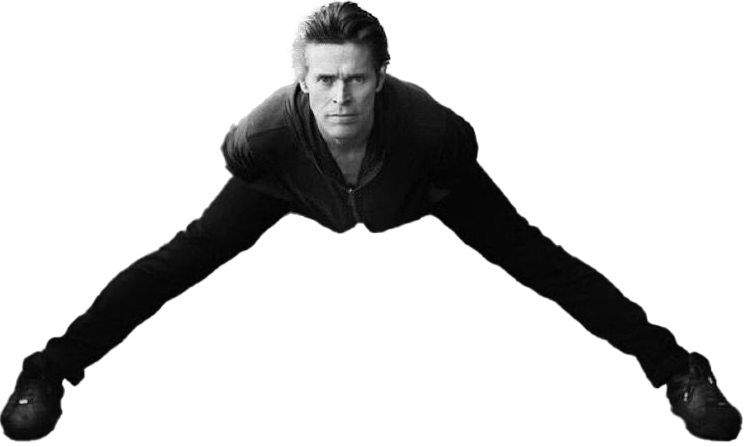

#TODO:

<br>

###Top Priority

---

####Cross-validation with both test-set and k-fold cross-validation
####Figure out what a loadings plot is
####Make a loadings plot for linear regression


---

<br>

###Second Priority

---


####Cast data_year columns to int
####Figure out why ethnicity_race_cols are converted to np.nan instead of float values
####Stop dropping other data years from county_df
####Replace Anti-Church of Jesus Christ bias with Anti-Mormon
####Add county demographic data from other years
####Get f-values for in merged_df?

#Import and Config

##Import all libraries

In [1]:
# Basics
import numpy as np
import re
import warnings


# Pandas
import pandas as pd


# Scikit-Learn
import sklearn as sk
from sklearn import preprocessing
from sklearn import metrics
from sklearn import model_selection
# Regressors
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
# Classifiers
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB



# Plotting libraries
from matplotlib import pyplot as plt
import seaborn as sns
import altair as alt

##Config

In [2]:
warnings.filterwarnings(action='ignore')

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
minimum_categorical_positive_count = 5
default_z_threshold_for_outliers = 2.5
# years to draw crime data from
years = [i for i in range(2010, 2020)] + [2021, 2022]
county_replacement_map = {
    "-": "Median on lower end of distribution",
    "+": "Median on upper end of distribution",
    # Number of samples too small for estimate
    "N": np.nan,
    # Estimate not applicable or not available
    "(X)": 0
}

##Import datasets

In [5]:
# Set of header keywords to remove
removalSet = {"SEX AND AGE!!", "SEX AND ", "Estimate!!", "Total!!", "Total population!!", "CITIZEN, VOTING AGE POPULATION!!", "AGE!!"}

# header prefixes to replace
col_replacement_dict = {
    "One or more races":"Two or more races"
}

# list of words found in columns that must be dropped
col_drop_keywords = "Margin of Error|SUMMARY INDICATORS|PERCENT ALLOCATED"

###Important functions

In [6]:
# use the entries of the first row as the column headers for easier management
def fixHeaders(df):
  new_headers = df.iloc[0]
  new_df = df[1:]
  new_df.columns = new_headers
  return new_df

In [7]:
def fix_column_names(df):
  new_cols = []
  for col in df.columns:
    col = str(col)

    for term in removalSet:
      if (term in col):
        col = col.replace(term, "")

    for original, replacement in col_replacement_dict.items():
      if original in col:
        col = col.replace(original, replacement)

    new_cols.append(col)

  return new_cols

#drop all margin of error columns from the county dataframe
def drop_cols_containing(df, pattern):
    df.drop(columns=list(df.filter(regex = pattern)), inplace = True)

In [8]:
def salvage_cols(df, missing_cols):
  # salvage columns missing from temp_df
    for col in missing_cols:

      # if there's a percent column missing
      if "Percent" in col:
        base = col.replace("Percent!!", "")

        # but the original population estimate exists
        if base in df.columns:

          # clean the demographic base column using the replacement map
          for original, replacement in county_replacement_map.items():
            df[[base]] = df[[base]].replace(original, replacement)

          # create a percent column
          df[col] = (df[base].astype(float)\
                     /df["Total population"].astype(float))\
                     * 100

In [9]:
def drop_duplicate_cols(df, keep):
  return df.loc[:, ~df.columns.duplicated(keep=keep)]

### Import datasets

In [10]:
crime_df = pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Analyzing-Hate-Crime-Data/main/datasets/hate_crime/hate_crime.csv", on_bad_lines='skip')

In [11]:
# create the county_df
county_df = pd.DataFrame()

# combine all datasets of the specified years
for year in years:
  temp_df = pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Analyzing-Hate-Crime-Data/main/datasets/demographics/county/data/ACSDP1Y" + str(year) + ".DP05-Data.csv", on_bad_lines='skip')

  #fix the headers
  temp_df = fixHeaders(temp_df)

  # standardize, clean the temp_df to make combining datasets more effective
  temp_df.columns = fix_column_names(temp_df)
  drop_cols_containing(temp_df, col_drop_keywords)


  # add a year column to distinguish entries from different years
  temp_df["data_year"] = year

  print("Imported " + str(year))

  if county_df.empty:
    county_df = temp_df.copy(deep=True)
  else:
    # keep only the last of column duplicates
    county_df = drop_duplicate_cols(county_df, "last")
    temp_df = drop_duplicate_cols(temp_df, "last")

    missing_cols = list(set(county_df.columns).difference(set(temp_df.columns)))

    salvage_cols(temp_df, missing_cols)

    missing_cols = list(set(county_df.columns).difference(set(temp_df.columns)))
    shared_cols = list(set(county_df.columns).intersection(set(temp_df.columns)))

    print("county_df shape: " + str(county_df.shape))
    print("temp_df shape: " + str(temp_df.shape))
    print("missing columns: " + str(missing_cols))
    print()

    # concatenate the county demographic datasets
    county_df = pd.concat([county_df[shared_cols], temp_df[shared_cols]], ignore_index=True)

# reindex the dataframe so it looks pretty
county_df = county_df.reindex(sorted(county_df.columns), axis=1)

Imported 2010
Imported 2011
county_df shape: (818, 150)
temp_df shape: (822, 150)
missing columns: []

Imported 2012
county_df shape: (1640, 150)
temp_df shape: (825, 150)
missing columns: []

Imported 2013
county_df shape: (2465, 150)
temp_df shape: (828, 158)
missing columns: ['RACE!!Black or African American', 'Percent!!RACE!!Some other race', 'RACE!!White', 'RACE!!American Indian and Alaska Native', 'Percent!!RACE!!Black or African American', 'RACE!!Native Hawaiian and Other Pacific Islander', 'RACE!!Asian', 'Percent!!RACE!!Native Hawaiian and Other Pacific Islander', 'Percent!!RACE!!Asian', 'Percent!!RACE!!White', 'RACE!!Some other race', 'Percent!!RACE!!American Indian and Alaska Native']

Imported 2014
county_df shape: (3293, 138)
temp_df shape: (828, 158)
missing columns: []

Imported 2015
county_df shape: (4121, 138)
temp_df shape: (830, 164)
missing columns: []

Imported 2016
county_df shape: (4951, 138)
temp_df shape: (831, 164)
missing columns: []

Imported 2017
county_df s

In [12]:
ethnicity_race_cols = set(pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Analyzing-Hate-Crime-Data/main/datasets/demographics/county/ethnicity_race_col_names", sep=";")["Percent!!RACE!!One race"])
ethnicity_race_cols = list(ethnicity_race_cols.intersection(set(county_df.columns)))
# ethnicity_race_cols

In [13]:
county_df.head()

10 to 14 years 15 to 19 years 18 years and over 20 to 24 years  \
0          12758          11710            141056           8429   
1           8536           9051             91549           8459   
2           5857           5874             61252           4970   
3           5352           4677             52607           4965   
4           4996           5009             61212           5920   

  21 years and over 25 to 34 years 35 to 44 years 45 to 54 years 5 to 9 years  \
0            134319          21568          23611          27276        11338   
1             84435          14368          15170          16674         6573   
2             57688           9232           9970          11979         4908   
3             49971           9040           9127           9118         5352   
4             58352          11214          11255          12308         5096   

  55 to 59 years 60 to 64 years 62 years and over 65 to 74 years  \
0          12278          12579             37328          18297   
1           8042           7126             21214           9385   
2           5858           4369             14672           7243   
3           4596           4091             12393           5663   
4           5249           4423             12114           5468   

  65 years and over 75 to 84 years 85 years and over Female  \
0             30657           9185              3175  16429   
1             17130           6093              1652  10079   
2             12625           3522              1860   7159   
3              9822           3382               777   5626   
4              9208           2783               957   5173   

      Geographic Area Name       Geography  \
0  Baldwin County, Alabama  0500000US01003   
1  Calhoun County, Alabama  0500000US01015   
2  Cullman County, Alabama  0500000US01043   
3   DeKalb County, Alabama  0500000US01049   
4   Elmore County, Alabama  0500000US01051   

  HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)  \
0                                               8078              
1                                               3981              
2                                               3497              
3                                               9622              
4                                               2159              

  HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Cuban  \
0                                                  N                     
1                                                  N                     
2                                                  N                     
3                                                  N                     
4                                                  N                     

  HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Mexican  \
0                                                  N                       
1                                                  N                       
2                                                  N                       
3                                                  N                       
4                                                  N                       

  HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Other Hispanic or Latino  \
0                                                  N                                        
1                                                  N                                        
2                                                  N                                        
3                                                  N                                        
4                                                  N                                        

  HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Puerto Rican  \
0                                                  N                            
1              

In [14]:
county_df.tail()

10 to 14 years 15 to 19 years 18 years and over 20 to 24 years  \
9981           7106           7954            109538           9002   
9982          15419          18844            283800          22569   
9983           4343           4016             55151           4768   
9984           3674           3444             61118           5802   
9985           2677           5010             56253           5801   

     21 years and over 25 to 34 years 35 to 44 years 45 to 54 years  \
9981            104901          17453          14249          14942   
9982            271753          44070          38288          40422   
9983             52972          10224           8414           9408   
9984             59797          10135           9222           9205   
9985             53690           7653           8903           8718   

     5 to 9 years 55 to 59 years 60 to 64 years 62 years and over  \
9981         6351           8294           8850             39382   
9982        13895          21154          23745            101009   
9983         2204           5095           4272             13567   
9984         3301           3962           5600             19612   
9985         1100           6616           2375             16555   

     65 to 74 years 65 years and over 75 to 84 years 85 years and over  \
9981          17018             33553          12540              3995   
9982          41007             85665          30094             14564   
9983           6467             11399           3364              1568   
9984           8191             16272           6688              1393   
9985           7707             14796           5366              1723   

      Female                  Geographic Area Name       Geography  \
9981   69383          Ponce Municipio, Puerto Rico  0500000US72113   
9982  182079       San Juan Municipio, Puerto Rico  0500000US72127   
9983   35049       Toa Alta Municipio, Puerto Rico  0500000US72135   
9984   38663       Toa Baja Municipio, Puerto Rico  0500000US72137   
9985   35559  Trujillo Alto Municipio, Puerto Rico  0500000US72139   

     HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)  \
9981                                             131448              
9982                                             327833              
9983                                              65855              
9984                                              72277              
9985                                              66088              

     HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Cuban  \
9981                                                266                     
9982                                               3412                     
9983                                                  N                     
9984                                                  N                     
9985                                                  N                     

     HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Mexican  \
9981                                                826                       
9982                                               1027                       
9983                                                  N                       
9984                                                  N                       
9985                                                  N                       

     HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Other Hispanic or Latino  \
9981                                               1466                                        
9982                                              37668                                        
9983                                                  N                                        
9984                                                  N                                        
9985                           

In [15]:
duplicate_cols = [x for x in county_df.columns if county_df.columns.tolist().count(x) > 1]
print("Duplicate columns: " + str(duplicate_cols))

Duplicate columns: []


#Data Cleaning

##Important Functions

In [16]:
def get_col_counts(df, unique_cols):
    # get the frequencies of categorical data based
    unique_col_counts = {}
    for value in unique_cols:
        if value in set(df.columns):
          unique_col_counts[value] = df[value].sum()
          # print(value)

    return unique_col_counts

In [17]:
def drop_outliers(df, numerical_cols, z_threshold=default_z_threshold_for_outliers):
    df_out = df.copy()  # Create a copy to avoid modifying the original DataFrame

    for column in numerical_cols:
        # Calculate Z-score for each value in the column
        z_scores = np.abs((df_out[column] - df_out[column].mean()) / df_out[column].std())

        print(z_scores.head())

        # Identify outliers based on Z-score
        outliers = df_out[z_scores > z_threshold]

        # Drop outliers from the DataFrame
        df_out = df_out.drop(outliers.index)

    return df_out

##Clean crime dataset

In [18]:
#only consider county data in scope
crime_df = crime_df[(crime_df['data_year'].isin(years)) & ((crime_df['agency_type_name'] == "County"))]

crime_df.reset_index(inplace=True)

In [19]:
crime_continuous_int_columns = ["index", "incident_id", "data_year"] + list(crime_df.select_dtypes("float64").columns)

crime_df[crime_continuous_int_columns].head()

index  incident_id  data_year  adult_victim_count  juvenile_victim_count  \
0  143544       143579       2010                 NaN                    NaN   
1  143547       143582       2010                 NaN                    NaN   
2  143555       143590       2010                 NaN                    NaN   
3  143556       143591       2010                 NaN                    NaN   
4  143557       143592       2010                 NaN                    NaN   

   adult_offender_count  juvenile_offender_count  total_individual_victims  
0                   NaN                      NaN                       1.0  
1                   NaN                      NaN                       2.0  
2                   NaN                      NaN                       1.0  
3                   NaN                      NaN                       1.0  
4                   NaN                      NaN                       1.0

In [20]:
crime_df.head()

index  incident_id  data_year        ori pug_agency_name pub_agency_unit  \
0  143544       143579       2010  AL0080000          Blount             NaN   
1  143547       143582       2010  AL0160000          Clarke             NaN   
2  143555       143590       2010  AL0630000      Tuscaloosa             NaN   
3  143556       143591       2010  AL0630000      Tuscaloosa             NaN   
4  143557       143592       2010  AL0630000      Tuscaloosa             NaN   

  agency_type_name state_abbr state_name       division_name region_name  \
0           County         AL    Alabama  East South Central       South   
1           County         AL    Alabama  East South Central       South   
2           County         AL    Alabama  East South Central       South   
3           County         AL    Alabama  East South Central       South   
4           County         AL    Alabama  East South Central       South   

  population_group_code              population_group_description  \
0                    9B      MSA counties from 25,000 thru 99,999   
1                    8C  Non-MSA counties from 10,000 thru 24,999   
2                    9B      MSA counties from 25,000 thru 99,999   
3                    9B      MSA counties from 25,000 thru 99,999   
4                    9B      MSA counties from 25,000 thru 99,999   

  incident_date  adult_victim_count  juvenile_victim_count  \
0    2010-06-03                 NaN                    NaN   
1    2010-02-18                 NaN                    NaN   
2    2010-09-01                 NaN                    NaN   
3    2010-06-16                 NaN                    NaN   
4    2010-06-16                 NaN                    NaN   

   total_offender_count  adult_offender_count  juvenile_offender_count  \
0                     1                   NaN                      NaN   
1                     4                   NaN                      NaN   
2                     1                   NaN                      NaN   
3                     1                   NaN                      NaN   
4                     1                   NaN                      NaN   

               offender_race offender_ethnicity  victim_count  \
0                      White      Not Specified             1   
1  Black or African American      Not Specified             2   
2                      White      Not Specified             1   
3  Black or African American      Not Specified             1   
4                      White      Not Specified             1   

                           offense_name  total_individual_victims  \
0                          Intimidation                       1.0   
1  Murder and Nonnegligent Manslaughter                       2.0   
2                          Intimidation                       1.0   
3                        Simple Assault                       1.0   
4                        Simple Assault                       1.0   

                        location_name                       bias_desc  \
0                      Residence/Home         Anti-Hispanic or Latino   
1                      Residence/Home             Anti-Other Religion   
2  Highway/Road/Alley/Street/Sidewalk  Anti-Black or African American   
3                      Residence/Home                      Anti-White   
4                      Residence/Home  Anti-Black or African American   

  victim_types multiple_offense multiple_bias  
0   Individual                S             S  
1   Individual                S             S  
2   Individual                S             S  
3   Individual                S             S  
4   Individual                S             S

In [21]:
crime_df.dtypes

index                             int64
incident_id                       int64
data_year                         int64
ori                              object
pug_agency_name                  object
pub_agency_unit                  object
agency_type_name                 object
state_abbr                       object
state_name                       object
division_name                    object
region_name                      object
population_group_code            object
population_group_description     object
incident_date                    object
adult_victim_count              float64
juvenile_victim_count           float64
total_offender_count              int64
adult_offender_count            float64
juvenile_offender_count         float64
offender_race                    object
offender_ethnicity               object
victim_count                      int64
offense_name                     object
total_individual_victims        float64
location_name                    object


### Create Geographic Area Name column for later merging

In [22]:
crime_df["Geographic Area Name"] = crime_df["pug_agency_name"].astype(str) + " "\
                                    + crime_df["agency_type_name"].astype(str) + ", "\
                                    + crime_df["state_name"].astype(str)

###Drop outliers and bad rows

In [23]:
crime_df.head()

index  incident_id  data_year        ori pug_agency_name pub_agency_unit  \
0  143544       143579       2010  AL0080000          Blount             NaN   
1  143547       143582       2010  AL0160000          Clarke             NaN   
2  143555       143590       2010  AL0630000      Tuscaloosa             NaN   
3  143556       143591       2010  AL0630000      Tuscaloosa             NaN   
4  143557       143592       2010  AL0630000      Tuscaloosa             NaN   

  agency_type_name state_abbr state_name       division_name region_name  \
0           County         AL    Alabama  East South Central       South   
1           County         AL    Alabama  East South Central       South   
2           County         AL    Alabama  East South Central       South   
3           County         AL    Alabama  East South Central       South   
4           County         AL    Alabama  East South Central       South   

  population_group_code              population_group_description  \
0                    9B      MSA counties from 25,000 thru 99,999   
1                    8C  Non-MSA counties from 10,000 thru 24,999   
2                    9B      MSA counties from 25,000 thru 99,999   
3                    9B      MSA counties from 25,000 thru 99,999   
4                    9B      MSA counties from 25,000 thru 99,999   

  incident_date  adult_victim_count  juvenile_victim_count  \
0    2010-06-03                 NaN                    NaN   
1    2010-02-18                 NaN                    NaN   
2    2010-09-01                 NaN                    NaN   
3    2010-06-16                 NaN                    NaN   
4    2010-06-16                 NaN                    NaN   

   total_offender_count  adult_offender_count  juvenile_offender_count  \
0                     1                   NaN                      NaN   
1                     4                   NaN                      NaN   
2                     1                   NaN                      NaN   
3                     1                   NaN                      NaN   
4                     1                   NaN                      NaN   

               offender_race offender_ethnicity  victim_count  \
0                      White      Not Specified             1   
1  Black or African American      Not Specified             2   
2                      White      Not Specified             1   
3  Black or African American      Not Specified             1   
4                      White      Not Specified             1   

                           offense_name  total_individual_victims  \
0                          Intimidation                       1.0   
1  Murder and Nonnegligent Manslaughter                       2.0   
2                          Intimidation                       1.0   
3                        Simple Assault                       1.0   
4                        Simple Assault                       1.0   

                        location_name                       bias_desc  \
0                      Residence/Home         Anti-Hispanic or Latino   
1                      Residence/Home             Anti-Other Religion   
2  Highway/Road/Alley/Street/Sidewalk  Anti-Black or African American   
3                      Residence/Home                      Anti-White   
4                      Residence/Home  Anti-Black or African American   

  victim_types multiple_offense multiple_bias        Geographic Area Name  
0   Individual                S             S      Blount County, Alabama  
1   Individual                S             S      Clarke County, Alabama  
2   Individual                S             S  Tuscaloosa County, Alabama  
3   Individual                S             S  Tuscaloosa County, Alabama  
4   Individual                S             S  Tuscaloosa County, Alabama

In [24]:
# crime_df.reset_index(inplace=True)
crime_df = drop_outliers(crime_df, crime_continuous_int_columns)

0    1.579044
1    1.578942
2    1.578669
3    1.578635
4    1.578601
Name: index, dtype: float64
0    0.922841
1    0.922836
2    0.922823
3    0.922822
4    0.922820
Name: incident_id, dtype: float64
0    1.576171
1    1.576171
2    1.576171
3    1.576171
4    1.576171
Name: data_year, dtype: float64
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: adult_victim_count, dtype: float64
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: juvenile_victim_count, dtype: float64
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: adult_offender_count, dtype: float64
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: juvenile_offender_count, dtype: float64
0    0.035438
1    0.894430
2    0.035438
3    0.035438
4    0.035438
Name: total_individual_victims, dtype: float64


In [25]:
crime_df.head()

index  incident_id  data_year        ori pug_agency_name pub_agency_unit  \
0  143544       143579       2010  AL0080000          Blount             NaN   
1  143547       143582       2010  AL0160000          Clarke             NaN   
2  143555       143590       2010  AL0630000      Tuscaloosa             NaN   
3  143556       143591       2010  AL0630000      Tuscaloosa             NaN   
4  143557       143592       2010  AL0630000      Tuscaloosa             NaN   

  agency_type_name state_abbr state_name       division_name region_name  \
0           County         AL    Alabama  East South Central       South   
1           County         AL    Alabama  East South Central       South   
2           County         AL    Alabama  East South Central       South   
3           County         AL    Alabama  East South Central       South   
4           County         AL    Alabama  East South Central       South   

  population_group_code              population_group_description  \
0                    9B      MSA counties from 25,000 thru 99,999   
1                    8C  Non-MSA counties from 10,000 thru 24,999   
2                    9B      MSA counties from 25,000 thru 99,999   
3                    9B      MSA counties from 25,000 thru 99,999   
4                    9B      MSA counties from 25,000 thru 99,999   

  incident_date  adult_victim_count  juvenile_victim_count  \
0    2010-06-03                 NaN                    NaN   
1    2010-02-18                 NaN                    NaN   
2    2010-09-01                 NaN                    NaN   
3    2010-06-16                 NaN                    NaN   
4    2010-06-16                 NaN                    NaN   

   total_offender_count  adult_offender_count  juvenile_offender_count  \
0                     1                   NaN                      NaN   
1                     4                   NaN                      NaN   
2                     1                   NaN                      NaN   
3                     1                   NaN                      NaN   
4                     1                   NaN                      NaN   

               offender_race offender_ethnicity  victim_count  \
0                      White      Not Specified             1   
1  Black or African American      Not Specified             2   
2                      White      Not Specified             1   
3  Black or African American      Not Specified             1   
4                      White      Not Specified             1   

                           offense_name  total_individual_victims  \
0                          Intimidation                       1.0   
1  Murder and Nonnegligent Manslaughter                       2.0   
2                          Intimidation                       1.0   
3                        Simple Assault                       1.0   
4                        Simple Assault                       1.0   

                        location_name                       bias_desc  \
0                      Residence/Home         Anti-Hispanic or Latino   
1                      Residence/Home             Anti-Other Religion   
2  Highway/Road/Alley/Street/Sidewalk  Anti-Black or African American   
3                      Residence/Home                      Anti-White   
4                      Residence/Home  Anti-Black or African American   

  victim_types multiple_offense multiple_bias        Geographic Area Name  
0   Individual                S             S      Blount County, Alabama  
1   Individual                S             S      Clarke County, Alabama  
2   Individual                S             S  Tuscaloosa County, Alabama  
3   Individual                S             S  Tuscaloosa County, Alabama  
4   Individual                S             S  Tuscaloosa County, Alabama

###Break up incident date information

In [26]:
def split_incident_date(date):
    result = date.split("-")

    return result + [np.nan] * (3 - len(result))

crime_df[["data_year", "incident_month", "incident_day"]] = crime_df["incident_date"]\
                                                              .map(split_incident_date)\
                                                              .apply(pd.Series)\
                                                              .astype(int)

In [27]:
crime_df[["data_year", "incident_month", "incident_day"]].dtypes

data_year         int64
incident_month    int64
incident_day      int64
dtype: object

###Break up crime_df categorical columns containing multiple categories into dummies

In [28]:
def multicol_parse(df, column, delimiter):
  prefix = column + "_"

  dummies = df[column]\
              .str\
              .get_dummies(sep=delimiter)\
              .add_prefix(prefix)
  dummies = dummies.astype(int)
  dummies.head()

  dummy_cols = list(dummies.columns)
  unique_values = [val.replace(prefix, "") for val in dummy_cols]

  # combine the dataframes
  new_df = pd.concat([df, dummies], axis=1)

  return unique_values, dummy_cols, new_df

In [29]:
crime_df.reset_index(inplace=True)

In [30]:
#Break up bias_desc column into dummy columns
unique_biases, bias_cols, crime_df = multicol_parse(crime_df, "bias_desc", ";")

In [31]:
#Break up victim_types column into dummy columns
unique_victim_types, victim_cols, crime_df = multicol_parse(crime_df, "victim_types", ";")

In [32]:
#Break up offense_names column into dummy columns
unique_offense_names, offense_cols, crime_df = multicol_parse(crime_df, "offense_name", ";")

In [33]:
#Break up location_names column into dummy columns
unique_location_names, location_cols, crime_df = multicol_parse(crime_df, "location_name", ";")

###Create dummy columns for other categorical variables

In [34]:
other_categorical_cols = ["Geographic Area Name", "agency_type_name", "division_name", "offender_race",
                          "offender_ethnicity", "state_name", "multiple_offense", "multiple_bias"]

In [35]:
other_categorical_cols

['Geographic Area Name',
 'agency_type_name',
 'division_name',
 'offender_race',
 'offender_ethnicity',
 'state_name',
 'multiple_offense',
 'multiple_bias']

In [36]:
crime_df.head()

level_0   index  incident_id  data_year        ori pug_agency_name  \
0        0  143544       143579       2010  AL0080000          Blount   
1        1  143547       143582       2010  AL0160000          Clarke   
2        2  143555       143590       2010  AL0630000      Tuscaloosa   
3        3  143556       143591       2010  AL0630000      Tuscaloosa   
4        4  143557       143592       2010  AL0630000      Tuscaloosa   

  pub_agency_unit agency_type_name state_abbr state_name       division_name  \
0             NaN           County         AL    Alabama  East South Central   
1             NaN           County         AL    Alabama  East South Central   
2             NaN           County         AL    Alabama  East South Central   
3             NaN           County         AL    Alabama  East South Central   
4             NaN           County         AL    Alabama  East South Central   

  region_name population_group_code              population_group_description  \
0       South                    9B      MSA counties from 25,000 thru 99,999   
1       South                    8C  Non-MSA counties from 10,000 thru 24,999   
2       South                    9B      MSA counties from 25,000 thru 99,999   
3       South                    9B      MSA counties from 25,000 thru 99,999   
4       South                    9B      MSA counties from 25,000 thru 99,999   

  incident_date  adult_victim_count  juvenile_victim_count  \
0    2010-06-03                 NaN                    NaN   
1    2010-02-18                 NaN                    NaN   
2    2010-09-01                 NaN                    NaN   
3    2010-06-16                 NaN                    NaN   
4    2010-06-16                 NaN                    NaN   

   total_offender_count  adult_offender_count  juvenile_offender_count  \
0                     1                   NaN                      NaN   
1                     4                   NaN                      NaN   
2                     1                   NaN                      NaN   
3                     1                   NaN                      NaN   
4                     1                   NaN                      NaN   

               offender_race offender_ethnicity  victim_count  \
0                      White      Not Specified             1   
1  Black or African American      Not Specified             2   
2                      White      Not Specified             1   
3  Black or African American      Not Specified             1   
4                      White      Not Specified             1   

                           offense_name  total_individual_victims  \
0                          Intimidation                       1.0   
1  Murder and Nonnegligent Manslaughter                       2.0   
2                          Intimidation                       1.0   
3                        Simple Assault                       1.0   
4                        Simple Assault                       1.0   

                        location_name                       bias_desc  \
0                      Residence/Home         Anti-Hispanic or Latino   
1                      Residence/Home             Anti-Other Religion   
2  Highway/Road/Alley/Street/Sidewalk  Anti-Black or African American   
3                      Residence/Home                      Anti-White   
4                      Residence/Home  Anti-Black or African American   

  victim_types multiple_offense multiple_bias        Geographic Area Name  \
0   Individual                S             S      Blount County, Alabama   
1   Individual                S             S      Clarke County, Alabama   
2   Individual                S             S  Tuscaloosa County, Alabama   
3   Individual                S             S  Tuscaloosa County, Alabama   
4   Individual                S             S  Tuscaloosa County, Alabama   

   incident_month  incident_day  \
0               6             3   


In [37]:
other_unique_categorical_cols = {}
for col in other_categorical_cols:
    unique_values = crime_df[col].unique()
    # print(unique_values)
    other_unique_categorical_cols[col] = [col + "_" + str(val) for val in unique_values]
print(other_unique_categorical_cols["Geographic Area Name"])

['Geographic Area Name_Blount County, Alabama', 'Geographic Area Name_Clarke County, Alabama', 'Geographic Area Name_Tuscaloosa County, Alabama', 'Geographic Area Name_Benton County, Arkansas', 'Geographic Area Name_Garland County, Arkansas', 'Geographic Area Name_Independence County, Arkansas', 'Geographic Area Name_Lonoke County, Arkansas', 'Geographic Area Name_Pulaski County, Arkansas', 'Geographic Area Name_Perry County, Arkansas', 'Geographic Area Name_White County, Arkansas', 'Geographic Area Name_Maricopa County, Arizona', 'Geographic Area Name_Pima County, Arizona', 'Geographic Area Name_Pinal County, Arizona', 'Geographic Area Name_Butte County, California', 'Geographic Area Name_Contra Costa County, California', 'Geographic Area Name_Kern County, California', 'Geographic Area Name_Lake County, California', 'Geographic Area Name_Los Angeles County, California', 'Geographic Area Name_Madera County, California', 'Geographic Area Name_Mendocino County, California', 'Geographic A

In [38]:
dummies = pd.get_dummies(crime_df[other_categorical_cols]).astype(int)
dummies.drop(columns=['multiple_offense_S', 'multiple_bias_S'], inplace=True)
other_unique_categorical_cols["multiple_offense"] = ["multiple_offense_M"]
other_unique_categorical_cols["multiple_bias"] = ["multiple_bias_M"]

# combine the dummy columns with crime_df
crime_df = pd.concat([crime_df, dummies], axis=1)

###List the categorical columns

In [39]:
# break up other_unique_categorical_cols because Python is being stupid
crime_categorical_cols = bias_cols\
                          + victim_cols\
                          + offense_cols\
                          + location_cols
for key, value in other_unique_categorical_cols.items():
  crime_categorical_cols += value

###Drop new bad columns

In [40]:
crime_df.drop(["level_0", "index"], axis=1, inplace=True)

##Clean county demographic dataset

In [41]:
county_str_cols = ["Geography", "Geographic Area Name", "Geographic Area Name", "agency_type_name", "state_name"]

# continuous quantitative variables
county_continuous_int_columns = ["Total population", "Under 5 years", "5 to 9 years", "45 to 54 years",\
                                 "10 to 14 years", "75 to 84 years", "60 to 64 years", "25 to 34 years",\
                                 "15 to 19 years", "20 to 24 years", "35 to 44 years", "55 to 59 years",\
                                 "65 to 74 years", "85 years and over"]

# age groups for the final df
age_groups = ['Under 5 years', '5 to 9 years', '10 to 14 years','15 to 19 years',\
              '20 to 24 years', '25 to 34 years', '35 to 44 years', '45 to 54 years',\
              '55 to 59 years', '60 to 64 years', '65 to 74 years', '75 to 84 years',\
              '85 years and over']

county_numerical_cols = list(set(county_df.columns).difference(set(county_str_cols)))

In [42]:
county_df.head()

10 to 14 years 15 to 19 years 18 years and over 20 to 24 years  \
0          12758          11710            141056           8429   
1           8536           9051             91549           8459   
2           5857           5874             61252           4970   
3           5352           4677             52607           4965   
4           4996           5009             61212           5920   

  21 years and over 25 to 34 years 35 to 44 years 45 to 54 years 5 to 9 years  \
0            134319          21568          23611          27276        11338   
1             84435          14368          15170          16674         6573   
2             57688           9232           9970          11979         4908   
3             49971           9040           9127           9118         5352   
4             58352          11214          11255          12308         5096   

  55 to 59 years 60 to 64 years 62 years and over 65 to 74 years  \
0          12278          12579             37328          18297   
1           8042           7126             21214           9385   
2           5858           4369             14672           7243   
3           4596           4091             12393           5663   
4           5249           4423             12114           5468   

  65 years and over 75 to 84 years 85 years and over Female  \
0             30657           9185              3175  16429   
1             17130           6093              1652  10079   
2             12625           3522              1860   7159   
3              9822           3382               777   5626   
4              9208           2783               957   5173   

      Geographic Area Name       Geography  \
0  Baldwin County, Alabama  0500000US01003   
1  Calhoun County, Alabama  0500000US01015   
2  Cullman County, Alabama  0500000US01043   
3   DeKalb County, Alabama  0500000US01049   
4   Elmore County, Alabama  0500000US01051   

  HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)  \
0                                               8078              
1                                               3981              
2                                               3497              
3                                               9622              
4                                               2159              

  HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Cuban  \
0                                                  N                     
1                                                  N                     
2                                                  N                     
3                                                  N                     
4                                                  N                     

  HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Mexican  \
0                                                  N                       
1                                                  N                       
2                                                  N                       
3                                                  N                       
4                                                  N                       

  HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Other Hispanic or Latino  \
0                                                  N                                        
1                                                  N                                        
2                                                  N                                        
3                                                  N                                        
4                                                  N                                        

  HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Puerto Rican  \
0                                                  N                            
1              

###Create area columns

In [43]:
# def split_area_name(area):
#     result = [np.nan, np.nan, np.nan]
#     if ", " in area:
#         result = area.split(", ") + [np.nan]

#     if " county" in result[0].lower():
#         result[0] = result[0][0:-7]
#         result[2] = result[1]
#         result[1] = "County"

#     return result + [np.nan] * (3 - len(result))

# def splitArea(df):
#     df[["Geographic Area Name", "agency_type_name", "state_name"]] = df["Geographic Area Name"].map(split_area_name).apply(pd.Series)

# splitArea(county_df)

###Remove irrelevant/bad columns and rows to line the dataframes up

In [44]:
# Drop columns that only contain NaN values
new_county_df = county_df.dropna(how='all', axis=1)

# get a list of the cols in the original df that aren't in the new one
dropped_cols = (set(county_df.columns)).difference(set(new_county_df.columns))

# remove the deleted columns from ethnicity_race_cols
ethnicity_race_cols = list((set(ethnicity_race_cols)).difference(set(dropped_cols)))

county_df = new_county_df

print(ethnicity_race_cols)

['Percent!!HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Other Hispanic or Latino', 'Percent!!RACE!!One race!!Asian!!Korean', 'Percent!!RACE!!One race!!American Indian and Alaska Native!!Sioux tribal grouping', 'Percent!!RACE!!One race!!American Indian and Alaska Native', 'Percent!!HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Mexican', 'Percent!!RACE!!One race!!Native Hawaiian and Other Pacific Islander!!Samoan', 'Percent!!RACE!!One race!!Asian!!Vietnamese', 'Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino', 'Percent!!RACE!!One race!!White', 'Percent!!RACE!!One race!!Asian!!Other Asian', 'Percent!!RACE!!One race!!Asian!!Filipino', 'Percent!!HISPANIC OR LATINO AND RACE!!Total population', 'Percent!!HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Cuban', 'Percent!!RACE!!One race!!Asian!!Asian Indian', 'Percent!!RACE!!One race!!American Indian and Alaska Native!!Chippewa tribal grouping', 'Percent!!RACE!!One race!!Black or Afr

In [45]:
print(len(county_numerical_cols))
print(len(county_df.columns))

#update the county_numerical_cols to exclude any dropped columns
county_numerical_cols = list(set(county_numerical_cols).intersection(set(county_df.columns)))

print(len(county_numerical_cols))
print(len(county_df.columns))

110
111
109
111


In [46]:
# fix any data indicated in county_replacement_map
for original, replacement in county_replacement_map.items():
  county_df[county_numerical_cols] = county_df[county_numerical_cols].replace(original, replacement)

In [47]:
# # Drop rows with NaN values in all of the ethnicity_race_cols
# county_df.dropna(subset=ethnicity_race_cols, how='all', inplace=True)

# replace missing ethnicity/race data with 0's;
#   ie if there were too few samples to estimate a certain ethnicity/race population/percentage, round to 0
county_df[county_numerical_cols] = county_df[county_numerical_cols].fillna(value=0)

In [48]:
county_df.head()

10 to 14 years 15 to 19 years 18 years and over 20 to 24 years  \
0          12758          11710            141056           8429   
1           8536           9051             91549           8459   
2           5857           5874             61252           4970   
3           5352           4677             52607           4965   
4           4996           5009             61212           5920   

  21 years and over 25 to 34 years 35 to 44 years 45 to 54 years 5 to 9 years  \
0            134319          21568          23611          27276        11338   
1             84435          14368          15170          16674         6573   
2             57688           9232           9970          11979         4908   
3             49971           9040           9127           9118         5352   
4             58352          11214          11255          12308         5096   

  55 to 59 years 60 to 64 years 62 years and over 65 to 74 years  \
0          12278          12579             37328          18297   
1           8042           7126             21214           9385   
2           5858           4369             14672           7243   
3           4596           4091             12393           5663   
4           5249           4423             12114           5468   

  65 years and over 75 to 84 years 85 years and over Female  \
0             30657           9185              3175  16429   
1             17130           6093              1652  10079   
2             12625           3522              1860   7159   
3              9822           3382               777   5626   
4              9208           2783               957   5173   

      Geographic Area Name       Geography  \
0  Baldwin County, Alabama  0500000US01003   
1  Calhoun County, Alabama  0500000US01015   
2  Cullman County, Alabama  0500000US01043   
3   DeKalb County, Alabama  0500000US01049   
4   Elmore County, Alabama  0500000US01051   

  HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)  \
0                                               8078              
1                                               3981              
2                                               3497              
3                                               9622              
4                                               2159              

  HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Cuban  \
0                                                  0                     
1                                                  0                     
2                                                  0                     
3                                                  0                     
4                                                  0                     

  HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Mexican  \
0                                                  0                       
1                                                  0                       
2                                                  0                       
3                                                  0                       
4                                                  0                       

  HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Other Hispanic or Latino  \
0                                                  0                                        
1                                                  0                                        
2                                                  0                                        
3                                                  0                                        
4                                                  0                                        

  HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Puerto Rican  \
0                                                  0                            
1              

###Fix column data types

In [49]:
county_df[county_numerical_cols] = county_df[county_numerical_cols].astype(float)

In [50]:
county_df[ethnicity_race_cols] = county_df[ethnicity_race_cols].astype(float)

In [51]:
# Convert the quantitative columns to int types
county_df[county_continuous_int_columns] = county_df[county_continuous_int_columns].astype(int)

###Drop outliers

In [52]:
# county_df = drop_outliers(county_df, county_continuous_int_columns + ethnicity_race_cols)

#Data Quality Check

##County demographics

In [53]:
county_df.head()

10 to 14 years  15 to 19 years  18 years and over  20 to 24 years  \
0           12758           11710           141056.0            8429   
1            8536            9051            91549.0            8459   
2            5857            5874            61252.0            4970   
3            5352            4677            52607.0            4965   
4            4996            5009            61212.0            5920   

   21 years and over  25 to 34 years  35 to 44 years  45 to 54 years  \
0           134319.0           21568           23611           27276   
1            84435.0           14368           15170           16674   
2            57688.0            9232            9970           11979   
3            49971.0            9040            9127            9118   
4            58352.0           11214           11255           12308   

   5 to 9 years  55 to 59 years  60 to 64 years  62 years and over  \
0         11338           12278           12579            37328.0   
1          6573            8042            7126            21214.0   
2          4908            5858            4369            14672.0   
3          5352            4596            4091            12393.0   
4          5096            5249            4423            12114.0   

   65 to 74 years  65 years and over  75 to 84 years  85 years and over  \
0           18297            30657.0            9185               3175   
1            9385            17130.0            6093               1652   
2            7243            12625.0            3522               1860   
3            5663             9822.0            3382                777   
4            5468             9208.0            2783                957   

    Female     Geographic Area Name       Geography  \
0  16429.0  Baldwin County, Alabama  0500000US01003   
1  10079.0  Calhoun County, Alabama  0500000US01015   
2   7159.0  Cullman County, Alabama  0500000US01043   
3   5626.0   DeKalb County, Alabama  0500000US01049   
4   5173.0   Elmore County, Alabama  0500000US01051   

   HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)  \
0                                             8078.0               
1                                             3981.0               
2                                             3497.0               
3                                             9622.0               
4                                             2159.0               

   HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Cuban  \
0                                                0.0                      
1                                                0.0                      
2                                                0.0                      
3                                                0.0                      
4                                                0.0                      

   HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Mexican  \
0                                                0.0                        
1                                                0.0                        
2                                                0.0                        
3                                                0.0                        
4                                                0.0                        

   HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Other Hispanic or Latino  \
0                                                0.0                                         
1                                                0.0                                         
2                                                0.0                                         
3                                                0.0                                         
4                                                0.0                                         

   HISPANIC OR LATINO AND RACE!!Hispanic or La

In [54]:
print("There are " + str(county_df.size) + " county data entries")

There are 1108446 county data entries


In [55]:
county_df["data_year"].unique()

array([2010., 2011., 2012., 2013., 2014., 2015., 2016., 2017., 2018.,
       2019., 2021., 2022.])

In [56]:
#get the total number of np.nan values
nan_counts = county_df.isnull().sum()
#  ...and the columns associated with them
nan_cols = [col for col in county_df.columns if nan_counts[col] > 0]
nan_counts.loc[nan_cols]

Series([], dtype: int64)

##Crime df

In [57]:
crime_df.head()

incident_id  data_year        ori pug_agency_name pub_agency_unit  \
0       143579       2010  AL0080000          Blount             NaN   
1       143582       2010  AL0160000          Clarke             NaN   
2       143590       2010  AL0630000      Tuscaloosa             NaN   
3       143591       2010  AL0630000      Tuscaloosa             NaN   
4       143592       2010  AL0630000      Tuscaloosa             NaN   

  agency_type_name state_abbr state_name       division_name region_name  \
0           County         AL    Alabama  East South Central       South   
1           County         AL    Alabama  East South Central       South   
2           County         AL    Alabama  East South Central       South   
3           County         AL    Alabama  East South Central       South   
4           County         AL    Alabama  East South Central       South   

  population_group_code              population_group_description  \
0                    9B      MSA counties from 25,000 thru 99,999   
1                    8C  Non-MSA counties from 10,000 thru 24,999   
2                    9B      MSA counties from 25,000 thru 99,999   
3                    9B      MSA counties from 25,000 thru 99,999   
4                    9B      MSA counties from 25,000 thru 99,999   

  incident_date  adult_victim_count  juvenile_victim_count  \
0    2010-06-03                 NaN                    NaN   
1    2010-02-18                 NaN                    NaN   
2    2010-09-01                 NaN                    NaN   
3    2010-06-16                 NaN                    NaN   
4    2010-06-16                 NaN                    NaN   

   total_offender_count  adult_offender_count  juvenile_offender_count  \
0                     1                   NaN                      NaN   
1                     4                   NaN                      NaN   
2                     1                   NaN                      NaN   
3                     1                   NaN                      NaN   
4                     1                   NaN                      NaN   

               offender_race offender_ethnicity  victim_count  \
0                      White      Not Specified             1   
1  Black or African American      Not Specified             2   
2                      White      Not Specified             1   
3  Black or African American      Not Specified             1   
4                      White      Not Specified             1   

                           offense_name  total_individual_victims  \
0                          Intimidation                       1.0   
1  Murder and Nonnegligent Manslaughter                       2.0   
2                          Intimidation                       1.0   
3                        Simple Assault                       1.0   
4                        Simple Assault                       1.0   

                        location_name                       bias_desc  \
0                      Residence/Home         Anti-Hispanic or Latino   
1                      Residence/Home             Anti-Other Religion   
2  Highway/Road/Alley/Street/Sidewalk  Anti-Black or African American   
3                      Residence/Home                      Anti-White   
4                      Residence/Home  Anti-Black or African American   

  victim_types multiple_offense multiple_bias        Geographic Area Name  \
0   Individual                S             S      Blount County, Alabama   
1   Individual                S             S      Clarke County, Alabama   
2   Individual                S             S  Tuscaloosa County, Alabama   
3   Individual                S             S  Tuscaloosa County, Alabama   
4   Individual                S             S  Tuscaloosa County, Alabama   

   incident_month  incident_day  \
0               6             3   
1               2            18   
2               9             1   
3               6            16 

In [58]:
#get the total number of np.nan values
nan_counts = crime_df.isnull().sum()
#  ...and the columns associated with them
nan_cols = [col for col in crime_df.columns if nan_counts[col] > 0]
nan_counts.loc[nan_cols]

pub_agency_unit             11581
adult_victim_count           3332
juvenile_victim_count        3379
adult_offender_count         4482
juvenile_offender_count      4484
total_individual_victims      320
dtype: int64

In [59]:
# crime_df.dtypes

#Data Engineering

##Perform power transformations and normalize data

###Transform data to Gaussian distributions

In [60]:
def transform_standardize_data(df, numerical_cols, categorical_cols):
  # increase subsampling size if df is bigger than the default size
  n_quantiles = len(df)
  subsample = 10000
  if n_quantiles > subsample:
    subsample = n_quantiles * 10

  print("Performing quantile transformation process...")
  # use a quantile transformer to normalize the data and since the PowerTransformer keeps shitting itself
  scaler = sk.preprocessing.QuantileTransformer(output_distribution="normal", n_quantiles=n_quantiles, subsample=subsample)
  transformed_data = scaler.fit_transform(df[numerical_cols])

  print("Renaming numerical columns...")
  for i, col in enumerate(numerical_cols):
    new_column_header = "transformed_" + col

    # update the list of numerical column labels
    numerical_cols[i] = new_column_header
    # add the transformed, standardized data back to the original dataframe
    df[new_column_header] = transformed_data[:, i]

  print("Dropping categorical columns with insufficient sample size...")
  # identify columns with insufficient sample sizes
  columns_to_drop = []
  for col in categorical_cols:
      if df[col].sum() < minimum_categorical_positive_count:
          columns_to_drop.append(col)

  # drop identified columns
  df.drop(columns_to_drop, axis=1, inplace=True)

  # update categorical_cols after dropping
  categorical_cols = [col for col in categorical_cols if col not in columns_to_drop]

In [61]:
crime_numerical_cols = list(crime_df.select_dtypes(include=['int64', 'float64']).columns)
county_numerical_cols = list(county_df.select_dtypes(include=["int64", "float64"]).columns)

In [62]:
# yeo-johnson transformation is super brittle and I'm not sure why
#transform the county data
transform_standardize_data(county_df, county_numerical_cols, [])

Performing quantile transformation process...
Renaming numerical columns...
Dropping categorical columns with insufficient sample size...


In [63]:
#transform the non-categorical data of crime_df
transform_standardize_data(crime_df,\
                            [col for col in crime_numerical_cols\
                                      if not col in crime_categorical_cols],\
                            crime_categorical_cols)

Performing quantile transformation process...
Renaming numerical columns...
Dropping categorical columns with insufficient sample size...


In [64]:
# remove columns that were removed from crime_df due to insufficient sample size from consideration
county_numerical_cols = [col for col in county_numerical_cols if col in set(county_df.columns)]

# remove columns that were removed from crime_df due to insufficient sample size from consideration
crime_numerical_cols = [col for col in crime_numerical_cols if col in set(crime_df.columns)]

In [65]:
print(crime_numerical_cols)

['incident_id', 'data_year', 'adult_victim_count', 'juvenile_victim_count', 'total_offender_count', 'adult_offender_count', 'juvenile_offender_count', 'victim_count', 'total_individual_victims', 'incident_month', 'incident_day', 'bias_desc_Anti-American Indian or Alaska Native', 'bias_desc_Anti-Arab', 'bias_desc_Anti-Asian', 'bias_desc_Anti-Atheism/Agnosticism', 'bias_desc_Anti-Bisexual', 'bias_desc_Anti-Black or African American', 'bias_desc_Anti-Buddhist', 'bias_desc_Anti-Catholic', 'bias_desc_Anti-Church of Jesus Christ', 'bias_desc_Anti-Eastern Orthodox (Russian, Greek, Other)', 'bias_desc_Anti-Female', 'bias_desc_Anti-Gay (Male)', 'bias_desc_Anti-Gender Non-Conforming', 'bias_desc_Anti-Heterosexual', 'bias_desc_Anti-Hindu', 'bias_desc_Anti-Hispanic or Latino', 'bias_desc_Anti-Islamic (Muslim)', "bias_desc_Anti-Jehovah's Witness", 'bias_desc_Anti-Jewish', 'bias_desc_Anti-Lesbian (Female)', 'bias_desc_Anti-Lesbian, Gay, Bisexual, or Transgender (Mixed Group)', 'bias_desc_Anti-Male',

In [66]:
# [col for col in crime_numerical_cols if not col in crime_categorical_cols]

##Extract additional features from the data

####Get hate crime rate per county

#####Get list of counties in the hate crime database

In [181]:
# print(set([col for col in crime_df.columns if "Geographic Area Name" in col]))

# Remove agencies that were dropped from the list of unique categorical columns
other_unique_categorical_cols["Geographic Area Name"] = list((set(other_unique_categorical_cols["Geographic Area Name"])).intersection(set(crime_df.columns)))
# print(other_unique_categorical_cols["Geographic Area Name"])

In [182]:
print(other_unique_categorical_cols)

{'Geographic Area Name': ['Geographic Area Name_Calhoun County, Michigan', 'Geographic Area Name_Greene County, Ohio', 'Geographic Area Name_Sullivan County, Tennessee', 'Geographic Area Name_Kaufman County, Texas', 'Geographic Area Name_Saginaw County, Michigan', 'Geographic Area Name_Labette County, Kansas', 'Geographic Area Name_El Paso County, Colorado', 'Geographic Area Name_Cumberland County, Maine', 'Geographic Area Name_Lewis and Clark County, Montana', 'Geographic Area Name_Platte County, Missouri', 'Geographic Area Name_Androscoggin County, Maine', 'Geographic Area Name_Jackson County, North Carolina', 'Geographic Area Name_Chesterfield County, South Carolina', 'Geographic Area Name_Mesa County, Colorado', 'Geographic Area Name_Berkeley County, South Carolina', 'Geographic Area Name_Washington County, Utah', 'Geographic Area Name_Ventura County, California', 'Geographic Area Name_Broome County, New York', 'Geographic Area Name_Nye County, Nevada', 'Geographic Area Name_Harfor

In [183]:
county_hate_counts = get_col_counts(crime_df, other_unique_categorical_cols["Geographic Area Name"])
county_hate_rates_df = pd.DataFrame.from_dict(data=county_hate_counts, orient='index', columns=['hate_crime_count'])

#####Clean dataframe

In [184]:
county_hate_rates_df["Geographic Area Name"] = county_hate_rates_df\
                                            .index\
                                            .str\
                                            .replace("Geographic Area Name_", "")

In [185]:
county_df["Geographic Area Name"].head()

0    Baldwin County, Alabama
1    Calhoun County, Alabama
2    Cullman County, Alabama
3     DeKalb County, Alabama
4     Elmore County, Alabama
Name: Geographic Area Name, dtype: object

In [186]:
county_hate_rates_df["Geographic Area Name"].head()

Geographic Area Name_Calhoun County, Michigan        Calhoun County, Michigan
Geographic Area Name_Greene County, Ohio                  Greene County, Ohio
Geographic Area Name_Sullivan County, Tennessee    Sullivan County, Tennessee
Geographic Area Name_Kaufman County, Texas              Kaufman County, Texas
Geographic Area Name_Saginaw County, Michigan        Saginaw County, Michigan
Name: Geographic Area Name, dtype: object

In [187]:
# only include demographic info related to each of the counties in the crime dataset
filtered_county_df = county_df[(county_df["Geographic Area Name"]).isin(county_hate_rates_df["Geographic Area Name"])]
filtered_county_df["Geography"].count()

3641

In [188]:
# merge the 2 datasets
county_hate_rates_df = county_hate_rates_df.merge(filtered_county_df, on="Geographic Area Name", how="outer")

In [189]:
county_hate_rates_df = county_hate_rates_df.dropna(subset=['Geography'])

#####Get hate crime rates

In [190]:
county_hate_rates_df["hate_crime_rate"] = county_hate_rates_df["hate_crime_count"]\
                                            .divide(county_hate_rates_df["Total population"])\
                                            .astype("float64")

In [191]:
# county_hate_rates_df.dropna(axis=1, how="all", inplace=True)

In [192]:
county_hate_rates_df.head()

hate_crime_count      Geographic Area Name  10 to 14 years  15 to 19 years  \
0                17  Calhoun County, Michigan          9630.0          9986.0   
1                17  Calhoun County, Michigan          9478.0         10061.0   
2                17  Calhoun County, Michigan          9919.0          8859.0   
3                17  Calhoun County, Michigan          7960.0          8930.0   
4                17  Calhoun County, Michigan          9338.0          8703.0   

   18 years and over  20 to 24 years  21 years and over  25 to 34 years  \
0           103158.0          8336.0            96595.0         16267.0   
1           103454.0          8330.0            97426.0         16396.0   
2           103097.0          8646.0            98014.0         16567.0   
3           103515.0          9076.0            98418.0         15377.0   
4           103576.0          9088.0            98505.0         16004.0   

   35 to 44 years  45 to 54 years  5 to 9 years  55 to 59 years  \
0         17115.0         19609.0        8835.0          9460.0   
1         16426.0         19660.0        8247.0          8282.0   
2         16729.0         18337.0        8200.0         10035.0   
3         17409.0         18148.0       10256.0         11211.0   
4         16576.0         18310.0        7968.0          8851.0   

   60 to 64 years  62 years and over  65 to 74 years  65 years and over  \
0          8254.0            24563.0         10341.0            20139.0   
1          9693.0            25811.0         10770.0            20473.0   
2          8667.0            25895.0         10991.0            20835.0   
3          6847.0            25385.0         12037.0            21854.0   
4          9677.0            26900.0         12268.0            21797.0   

   75 to 84 years  85 years and over   Female       Geography  \
0          6961.0             2837.0  11329.0  0500000US26025   
1          6898.0             2805.0  11769.0  0500000US26025   
2          6191.0             3653.0  11757.0  0500000US26025   
3          6508.0             3309.0  69468.0  0500000US26025   
4          6419.0             3110.0  68632.0  0500000US26025   

   HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)  \
0                                             6211.0               
1                                             6259.0               
2                                             6259.0               
3                                             6314.0               
4                                             6425.0               

   HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Cuban  \
0                                                0.0                      
1                                                0.0                      
2                                                0.0                      
3                                                0.0                      
4                                                0.0                      

   HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Mexican  \
0                                                0.0                        
1                                                0.0                        
2                                                0.0                        
3                                                0.0                        
4                                                0.0                        

   HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Other Hispanic or Latino  \
0                                                0.0                                         
1                                                0.0                                         
2                                                0.0                                         
3                                                0.0                                         
4                          

<Axes: ylabel='Frequency'>

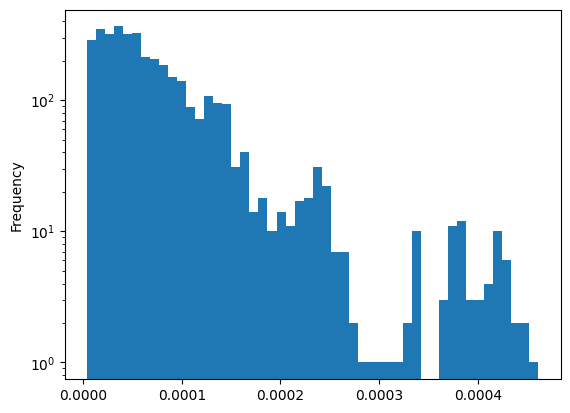

In [193]:
county_hate_rates_df["hate_crime_rate"].plot.hist(bins=50, logy=True)

####Create a categorical variable for classification testing

In [194]:
crime_df["region_name"].unique()

array(['South', 'West', 'Midwest', 'Northeast'], dtype=object)

In [195]:
county_hate_rates_df["region"] = crime_df["region_name"].map({"South":3, "West":2, "Midwest":1, "Northeast":0})

####Transform and normalize the data

In [196]:
hate_features = ["hate_crime_count", "hate_crime_rate"]

# save the hate feature data for adding back later
hate_crime_rates_df = county_hate_rates_df[hate_features]

In [197]:
# transform the hate_crime_rate data
transform_standardize_data(county_hate_rates_df, hate_features + ["region"], [])

Performing quantile transformation process...
Renaming numerical columns...
Dropping categorical columns with insufficient sample size...


<Axes: ylabel='Frequency'>

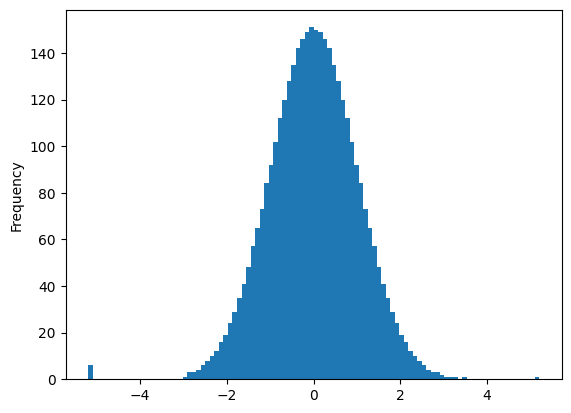

In [198]:
county_hate_rates_df['transformed_hate_crime_rate'].plot.hist(bins=100)

In [199]:
# add the original hate rates back to the county_hate_rates_df
county_hate_rates_df = pd.concat([county_hate_rates_df, hate_crime_rates_df], axis=1, join="outer")

In [200]:
hate_rate_numerical_cols = [col for col in county_hate_rates_df\
                              .select_dtypes(include=["int64", "float64"])\
                              .columns if (("transformed" in col)\
                                           or (col in hate_features))]

county_hate_rates_df = county_hate_rates_df[hate_rate_numerical_cols]

In [201]:
county_hate_rates_df.fillna(value=0, inplace=True)

In [202]:
county_hate_rates_df.head()

hate_crime_count  hate_crime_count  transformed_10 to 14 years  \
0                17                17                   -0.074124   
1                17                17                   -0.091128   
2                17                17                   -0.034274   
3                17                17                   -0.289291   
4                17                17                   -0.108031   

   transformed_15 to 19 years  transformed_18 years and over  \
0                   -0.116115                      -0.194136   
1                   -0.106895                      -0.190045   
2                   -0.267111                      -0.195160   
3                   -0.255940                      -0.189023   
4                   -0.288506                      -0.188000   

   transformed_20 to 24 years  transformed_21 years and over  \
0                   -0.311879                      -0.193113   
1                   -0.312933                      -0.183403   
2                   -0.272057                      -0.176769   
3                   -0.211177                      -0.171672   
4                   -0.208996                      -0.170653   

   transformed_25 to 34 years  transformed_35 to 44 years  \
0                   -0.240407                   -0.145994   
1                   -0.228795                   -0.184169   
2                   -0.212717                   -0.169125   
3                   -0.301091                   -0.126990   
4                   -0.256718                   -0.177279   

   transformed_45 to 54 years  transformed_5 to 9 years  \
0                   -0.058777                 -0.126737   
1                   -0.055382                 -0.203226   
2                   -0.145233                 -0.208611   
3                   -0.155897                  0.045579   
4                   -0.146882                 -0.243767   

   transformed_55 to 59 years  transformed_60 to 64 years  \
0                   -0.097936                   -0.195799   
1                   -0.269843                    0.004770   
2                   -0.034022                   -0.128255   
3                    0.092640                   -0.447129   
4                   -0.175495                    0.002385   

   transformed_62 years and over  transformed_65 to 74 years  \
0                      -0.226991                   -0.391344   
1                      -0.162762                   -0.322174   
2                      -0.158693                   -0.294531   
3                      -0.182893                   -0.171417   
4                      -0.113083                   -0.145487   

   transformed_65 years and over  transformed_75 to 84 years  \
0                      -0.206430                   -0.031636   
1                      -0.185063                   -0.041559   
2                      -0.161236                   -0.178682   
3                      -0.104749                   -0.110557   
4                      -0.107274                   -0.129521   

   transformed_85 years and over  transformed_Female  \
0                      -0.010795           -1.178599   
1                      -0.025232           -1.155289   
2                       0.250626           -1.156268   
3                       0.153102            0.152594   
4                       0.092892            0.140668   

   transformed_HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)  \
0                                          -0.436887                           
1                                          -0.428341                           
2                                          -0.428341                           
3                                          -0.422296                           
4                                          -0.406703                           

   transformed_HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Cuban  \
0                                          -5.199338  

##Merge the datasets

In [90]:
# combine the crime and population datasets
merged_df = pd.merge(crime_df, county_df, on=["Geographic Area Name", "data_year"], how="inner")

In [91]:
merged_df.drop(other_unique_categorical_cols["Geographic Area Name"] + ["ori", "state_abbr", "population_group_code", "pub_agency_unit",
                "Geography", "Percent!!Total population", "population_group_description",
                "pug_agency_name", "incident_date", "pub_agency_unit", "Geographic Area Name",
                "agency_type_name", "state_name", "division_name", "offender_race", "offender_ethnicity",
                "location_name", "bias_desc", "victim_types", "multiple_offense",
                  "multiple_bias"], axis=1, inplace=True)

In [92]:
merged_df.dropna(axis=1, how="all", inplace=True)

In [93]:
merged_df.head()

incident_id  data_year region_name  adult_victim_count  \
0       143590       2010       South                 NaN   
1       143591       2010       South                 NaN   
2       143592       2010       South                 NaN   
3       143593       2010       South                 NaN   
4       143594       2010       South                 NaN   

   juvenile_victim_count  total_offender_count  adult_offender_count  \
0                    NaN                     1                   NaN   
1                    NaN                     1                   NaN   
2                    NaN                     1                   NaN   
3                    NaN                     0                   NaN   
4                    NaN                     1                   NaN   

   juvenile_offender_count  victim_count    offense_name  \
0                      NaN             1    Intimidation   
1                      NaN             1  Simple Assault   
2                      NaN             1  Simple Assault   
3                      NaN             1    Intimidation   
4                      NaN             1  Simple Assault   

   total_individual_victims  incident_month  incident_day  \
0                       1.0               9             1   
1                       1.0               6            16   
2                       1.0               6            16   
3                       1.0               4             5   
4                       1.0               4             2   

   bias_desc_Anti-American Indian or Alaska Native  bias_desc_Anti-Arab  \
0                                                0                    0   
1                                                0                    0   
2                                                0                    0   
3                                                0                    0   
4                                                0                    0   

   bias_desc_Anti-Asian  bias_desc_Anti-Atheism/Agnosticism  \
0                     0                                   0   
1                     0                                   0   
2                     0                                   0   
3                     0                                   0   
4                     0                                   0   

   bias_desc_Anti-Bisexual  bias_desc_Anti-Black or African American  \
0                        0                                         1   
1                        0                                         0   
2                        0                                         1   
3                        0                                         1   
4                        0                                         1   

   bias_desc_Anti-Buddhist  bias_desc_Anti-Catholic  \
0                        0                        0   
1                        0                        0   
2                        0                        0   
3                        0                        0   
4                        0                        0   

   bias_desc_Anti-Church of Jesus Christ  \
0                                      0   
1                                      0   
2                                      0   
3                                      0   
4                                      0   

   bias_desc_Anti-Eastern Orthodox (Russian, Greek, Other)  \
0                                                  0         
1                                                  0         
2                                                  0         
3                                                  0         
4                                                  0         

   bias_desc_Anti-Female  bias_desc_Anti-Gay (Male)  \
0                      0                          0   
1                      0                          0   
2                      0                          0   
3                      

#Data Exploration

##Important Functions

In [94]:
def get_sorted_corrs(corr):
  # Unstack and rename corr
  corr_sorted = pd.DataFrame(corr.unstack()).reset_index()
  corr_sorted.columns = ["feature1", "feature2", "corr"]

  # Get highest correlation coefficient pairs
  corr_sorted["abs_corr"] = corr_sorted["corr"].abs()
  corr_sorted.sort_values(by="abs_corr", ascending=False, inplace=True)

  #reset the indices
  corr_sorted.reset_index(inplace=True)

  #filter out self-correlations
  corr_sorted = corr_sorted[~(corr_sorted["feature1"] == corr_sorted["feature2"])]

  #filter out stray index rows
  corr_sorted = corr_sorted[~corr_sorted["feature1"].str.contains("level_0|index")]
  corr_sorted = corr_sorted[~corr_sorted["feature2"].str.contains("level_0|index")]

  # remove duplicates
  # only keep even-numbered rows, since there will be 2 of every correlation
  corr_sorted = corr_sorted.iloc[::2]
  # corr_sorted = corr_sorted.dropna().groupby("feature1")

  return corr_sorted

In [95]:
def do_corr_analysis(corr, minThreshold, maxThreshold, blacklistPhraseRegex, corr_sorted=None):
    # get the sorted correlation coefficients
    if corr_sorted is None:
      sorted_corrs = get_sorted_corrs(corr)
    else:
      sorted_corrs = corr_sorted

    # create subplot display
    fig, ax = plt.subplots(3, figsize=(10, 20))

    # plot stuff
    sorted_corrs["corr"].plot.hist(bins=40, logy=True, ax=ax[0], title="Correlation Coefficients")
    sorted_corrs["abs_corr"].plot.hist(bins=40, logy=True, ax=ax[1], title="Correlation Coefficients' Absolute Values")

    # filter down to correlations of interest
    corrs_of_interest = sorted_corrs[(sorted_corrs["abs_corr"] > minThreshold) & (sorted_corrs["abs_corr"] < maxThreshold)
                                      & (~sorted_corrs["feature1"].str.contains(blacklistPhraseRegex))
                                      & (~sorted_corrs["feature2"].str.contains(blacklistPhraseRegex))]

    # plot the remaining correlations
    corrs_of_interest["corr"].plot.hist(bins=50, logy=True, ax=ax[2], title="Correlation Coefficients of Interest")

    return sorted_corrs, corrs_of_interest

##Individual Datasets

###Hate Crime Dataset

In [96]:
crime_df.head()

incident_id  data_year        ori pug_agency_name pub_agency_unit  \
0       143579       2010  AL0080000          Blount             NaN   
1       143582       2010  AL0160000          Clarke             NaN   
2       143590       2010  AL0630000      Tuscaloosa             NaN   
3       143591       2010  AL0630000      Tuscaloosa             NaN   
4       143592       2010  AL0630000      Tuscaloosa             NaN   

  agency_type_name state_abbr state_name       division_name region_name  \
0           County         AL    Alabama  East South Central       South   
1           County         AL    Alabama  East South Central       South   
2           County         AL    Alabama  East South Central       South   
3           County         AL    Alabama  East South Central       South   
4           County         AL    Alabama  East South Central       South   

  population_group_code              population_group_description  \
0                    9B      MSA counties from 25,000 thru 99,999   
1                    8C  Non-MSA counties from 10,000 thru 24,999   
2                    9B      MSA counties from 25,000 thru 99,999   
3                    9B      MSA counties from 25,000 thru 99,999   
4                    9B      MSA counties from 25,000 thru 99,999   

  incident_date  adult_victim_count  juvenile_victim_count  \
0    2010-06-03                 NaN                    NaN   
1    2010-02-18                 NaN                    NaN   
2    2010-09-01                 NaN                    NaN   
3    2010-06-16                 NaN                    NaN   
4    2010-06-16                 NaN                    NaN   

   total_offender_count  adult_offender_count  juvenile_offender_count  \
0                     1                   NaN                      NaN   
1                     4                   NaN                      NaN   
2                     1                   NaN                      NaN   
3                     1                   NaN                      NaN   
4                     1                   NaN                      NaN   

               offender_race offender_ethnicity  victim_count  \
0                      White      Not Specified             1   
1  Black or African American      Not Specified             2   
2                      White      Not Specified             1   
3  Black or African American      Not Specified             1   
4                      White      Not Specified             1   

                           offense_name  total_individual_victims  \
0                          Intimidation                       1.0   
1  Murder and Nonnegligent Manslaughter                       2.0   
2                          Intimidation                       1.0   
3                        Simple Assault                       1.0   
4                        Simple Assault                       1.0   

                        location_name                       bias_desc  \
0                      Residence/Home         Anti-Hispanic or Latino   
1                      Residence/Home             Anti-Other Religion   
2  Highway/Road/Alley/Street/Sidewalk  Anti-Black or African American   
3                      Residence/Home                      Anti-White   
4                      Residence/Home  Anti-Black or African American   

  victim_types multiple_offense multiple_bias        Geographic Area Name  \
0   Individual                S             S      Blount County, Alabama   
1   Individual                S             S      Clarke County, Alabama   
2   Individual                S             S  Tuscaloosa County, Alabama   
3   Individual                S             S  Tuscaloosa County, Alabama   
4   Individual                S             S  Tuscaloosa County, Alabama   

   incident_month  incident_day  \
0               6             3   
1               2            18   
2               9             1   
3               6            16 

####Correlation matrix

In [97]:
for item in ['level_0', 'index', 'incident_id', 'data_year']:
  if item in crime_numerical_cols:
    crime_numerical_cols.remove(item)

In [98]:
# Create a correlation matrix
crime_corr = crime_df[crime_numerical_cols].dropna().corr()

In [99]:
# # Set the figure size
# plt.figure(figsize=(200, 100))

# # Create a heatmap of the correlation matrix
# sns.heatmap(crime_corr, annot=True)

# # Show the plot
# plt.show()

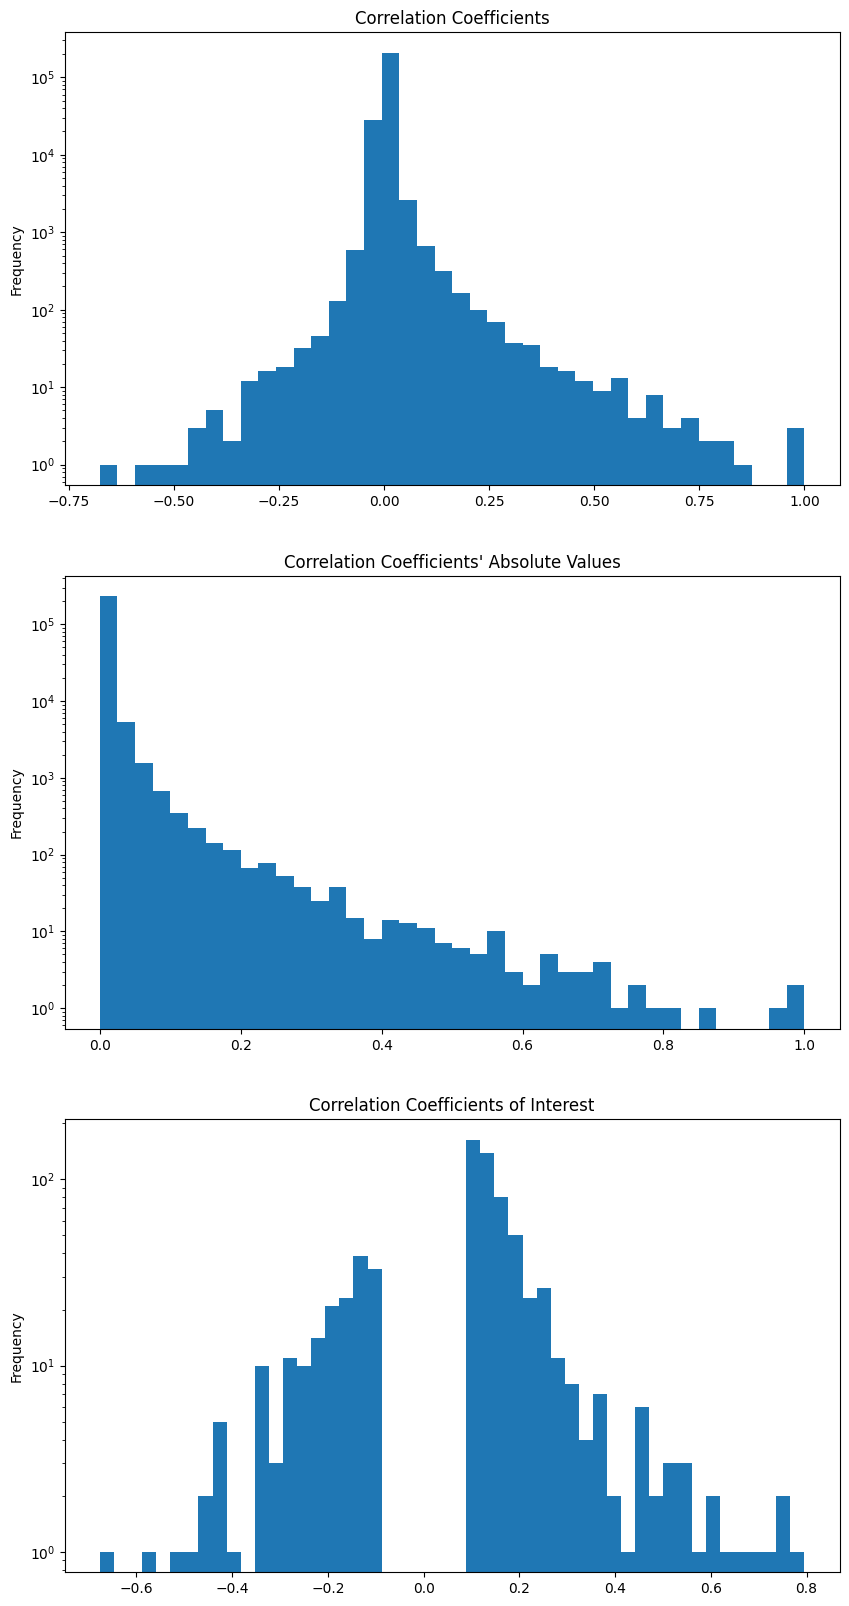

In [100]:
sorted_crime_corrs, crime_corrs_of_interest = do_corr_analysis(crime_corr, 0.1, 1, "Geographic Area Name|state_name")

In [101]:
crime_corrs_of_interest

index                                           feature1  \
703    66225       location_name_Church/Synagogue/Temple/Mosque   
705    32390                            victim_types_Individual   
707    35260                        victim_types_Society/Public   
715   449200                      division_name_Middle Atlantic   
719   401918  Geographic Area Name_Suffolk County Police Dep...   
723   459659                                offender_race_White   
725   457252  offender_race_Native Hawaiian or Other Pacific...   
731     8745                 bias_desc_Anti-Atheism/Agnosticism   
743   314622       Geographic Area Name_Nassau County, New York   
747    81598                        location_name_Other/Unknown   
749   461776          offender_ethnicity_Not Hispanic or Latino   
751        3                                 adult_victim_count   
771      708                              juvenile_victim_count   
773     4229                           total_individual_victims   
777   401328  Geographic Area Name_Suffolk County Police Dep...   
779   462481                   offender_ethnicity_Not Specified   
783   494213                                 multiple_offense_M   
785     4224                           total_individual_victims   
789   458362                              offender_race_Unknown   
793   197066       Geographic Area Name_Fort Bend County, Texas   
807    41586             offense_name_Drug Equipment Violations   
809      656                                 adult_victim_count   
813    19646                              bias_desc_Anti-Jewish   
815    34238                                 victim_types_Other   
817    33907                                 victim_types_Other   
821    19056                              bias_desc_Anti-Jewish   
823    59186                 offense_name_Weapon Law Violations   
829     2763                               adult_offender_count   
833     2939                            juvenile_offender_count   
841   458306                              offender_race_Unknown   
853    32434                            victim_types_Individual   
855     2768                               adult_offender_count   
859   456140            offender_race_Black or African American   
861    32432                            victim_types_Individual   
867    32427                            victim_types_Individual   
869   314099       Geographic Area Name_Nassau County, New York   
875       46                                 adult_victim_count   
877   401395  Geographic Area Name_Suffolk County Police Dep...   
879    40878  offense_name_Destruction/Damage/Vandalism of P...   
887   444864            Geographic Area Name_York County, Maine   
905    19454                              bias_desc_Anti-Jewish   
919   461123          offender_ethnicity_Not Hispanic or Latino   
921    64108                location_name_Bank/Savings and Loan   
923   448994                   division_name_East South Central   
925   451656                              division_name_Pacific   
927    33850                                 victim_types_Other   
929    86593          location_name_School-Elementary/Secondary   
931    33798                                 victim_types_Other   
943   458959                              offender_race_Unknown   
947   450935                          division_name_New England   
949     4274                           total_individual_victims   
967    32444                            victim_types_Individual   
969     4267                           total_individual_victims   
975   449198                      division_name_Middle Atlantic   
977     2114                               adult_offender_count   
981    40859  offense_name_Destruction/Damage/Vandalism of P...   
987    41484  offense_name_Destruction/Damage/Vandalism of P...   
989    40838  offense_name_Destruction/Damage/Vandalism of P...   
997    54266                        offense_name_Simpl

####Quantitative variable figures

<Axes: title={'center': 'total_offender_count'}, ylabel='Frequency'>

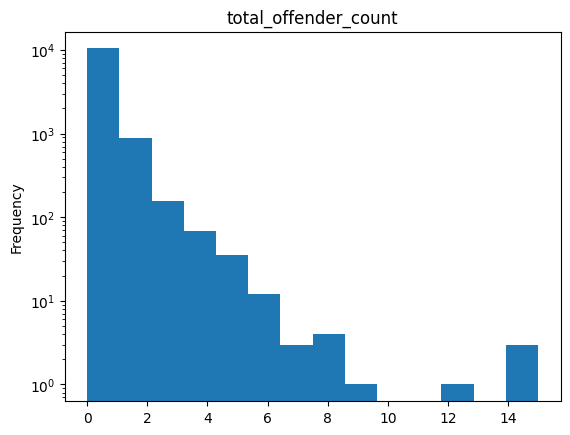

In [102]:
crime_df['total_offender_count'].plot.hist(bins=14, title='total_offender_count', logy=True)

<Axes: title={'center': 'adult_victim_count'}, ylabel='Frequency'>

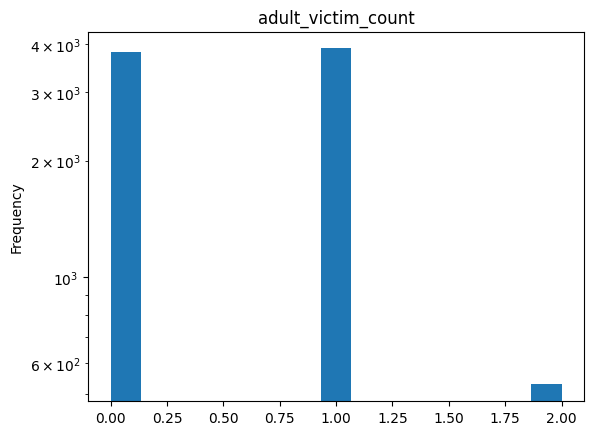

In [103]:
crime_df['adult_victim_count'].plot.hist(bins=15, title='adult_victim_count', logy=True)

<Axes: title={'center': 'juvenile_victim_count'}, ylabel='Frequency'>

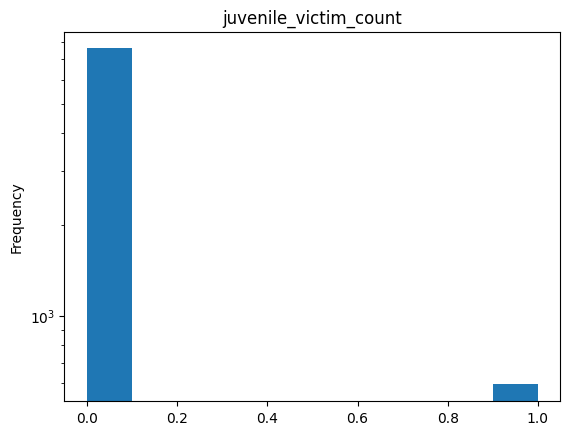

In [104]:
crime_df['juvenile_victim_count'].plot.hist(bins=10, title='juvenile_victim_count', logy=True)

####Categorical variable figures


In [105]:
def plot_column_counts(df, column_name, unique_values, title_phrase, figsize=(20, 5), rotation=90):
    # Create a dictionary of unique values and their counts
    unique_value_counts = get_col_counts(df, unique_values)

    # Sort the dictionary by values in descending order
    sorted_value_counts = dict(sorted(unique_value_counts.items(), key=lambda item: item[1], reverse=True))

    # Create a bar chart of the sorted valuees and their counts
    plt.figure(figsize=figsize)
    sns.barplot(x=list(sorted_value_counts.keys()), y=list(sorted_value_counts.values()), log=True)

    # Set the title and labels
    plt.title("Frequency of " + title_phrase + " in Hate Crimes", fontsize=16)
    plt.xlabel(title_phrase, fontsize=14)
    plt.ylabel("Frequency (Log Scale)", fontsize=14)

    # Rotate the x-axis labels for readability
    plt.xticks(rotation=rotation)

    # Show the plot
    plt.show()


(array([0, 1, 2, 3]),
 [Text(0, 0, 'South'),
  Text(1, 0, 'West'),
  Text(2, 0, 'Midwest'),
  Text(3, 0, 'Northeast')])

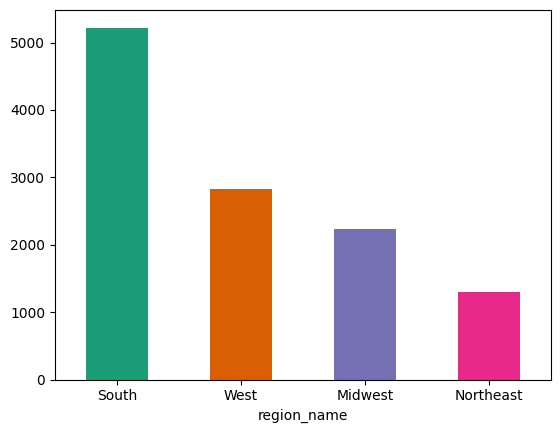

In [106]:
crime_df.groupby('region_name').size().sort_values(ascending=False).plot.bar(color=sns.palettes.mpl_palette('Dark2'))
plt.xticks(rotation=0)

<Axes: ylabel='offender_race'>

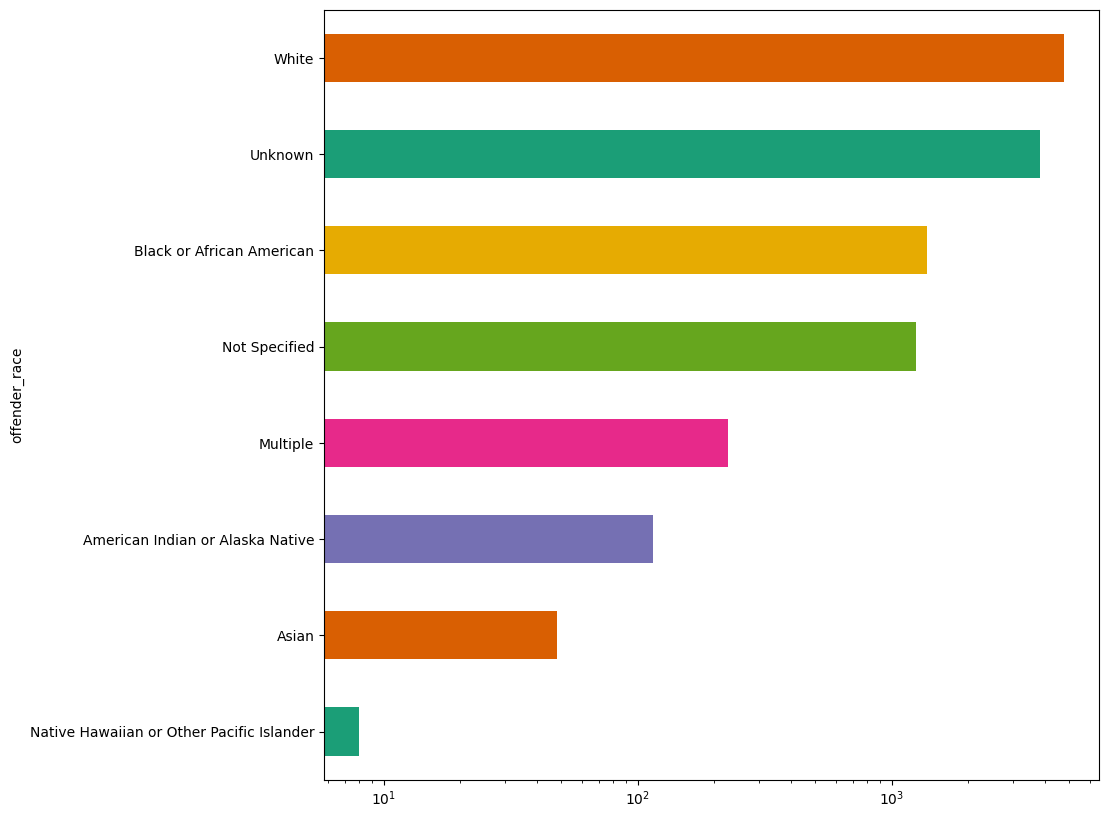

In [107]:
crime_df.groupby('offender_race').size().sort_values(ascending=True).plot.barh(color=sns.palettes.mpl_palette('Dark2'), figsize=(10,10), logx=True)

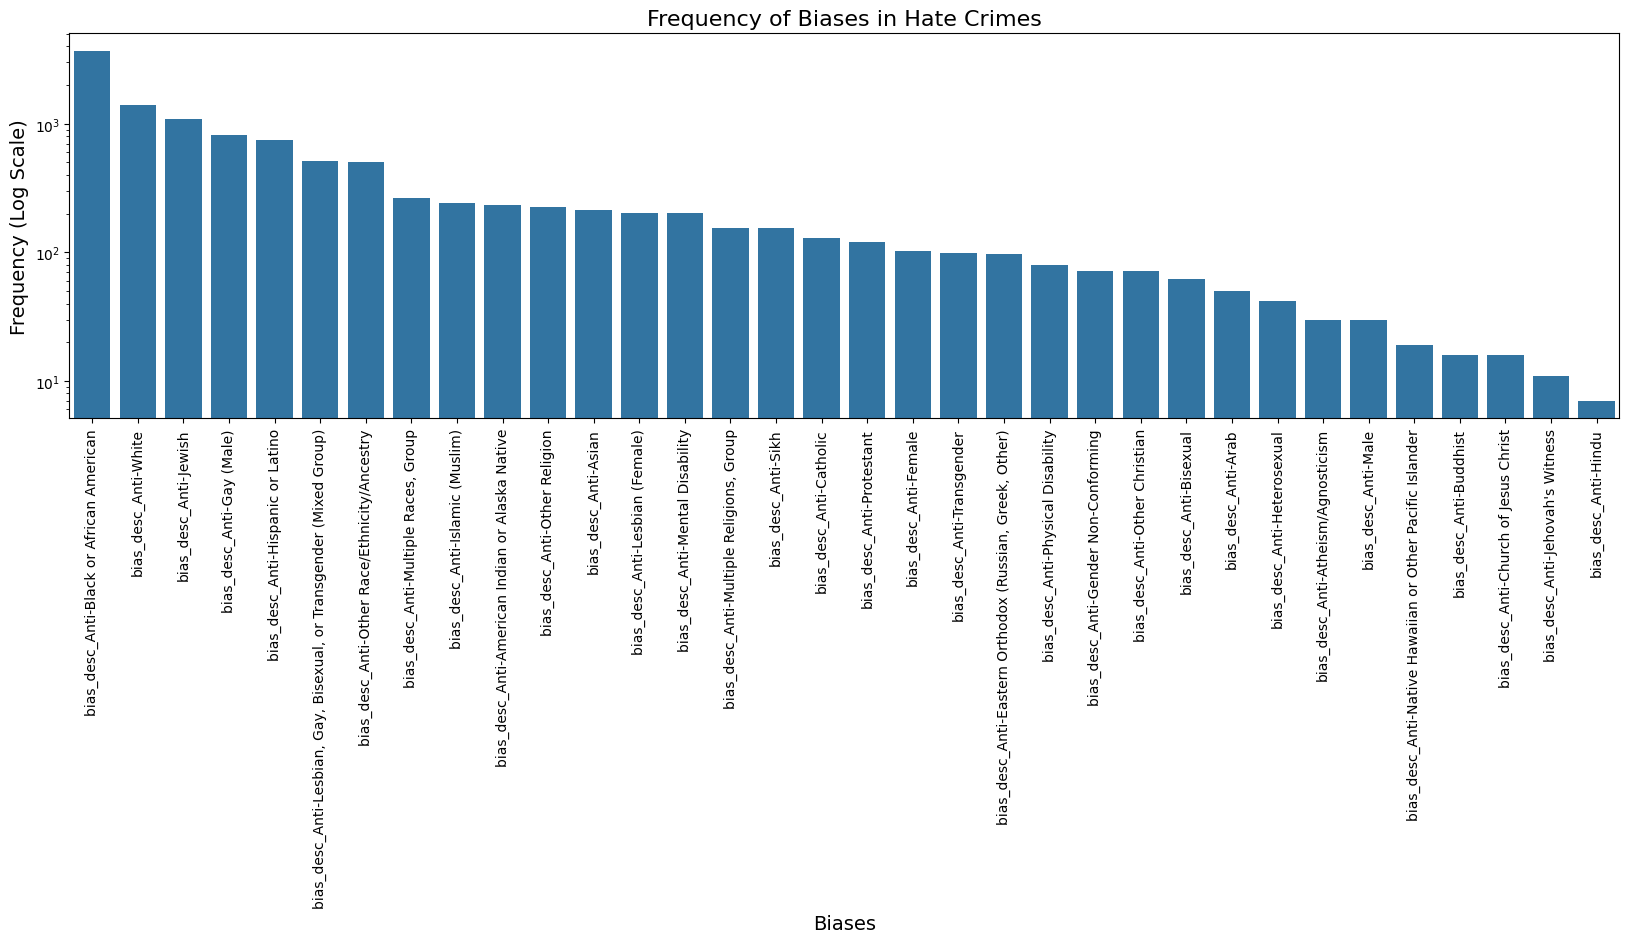

In [108]:
plot_column_counts(crime_df, "bias_desc", bias_cols, "Biases")

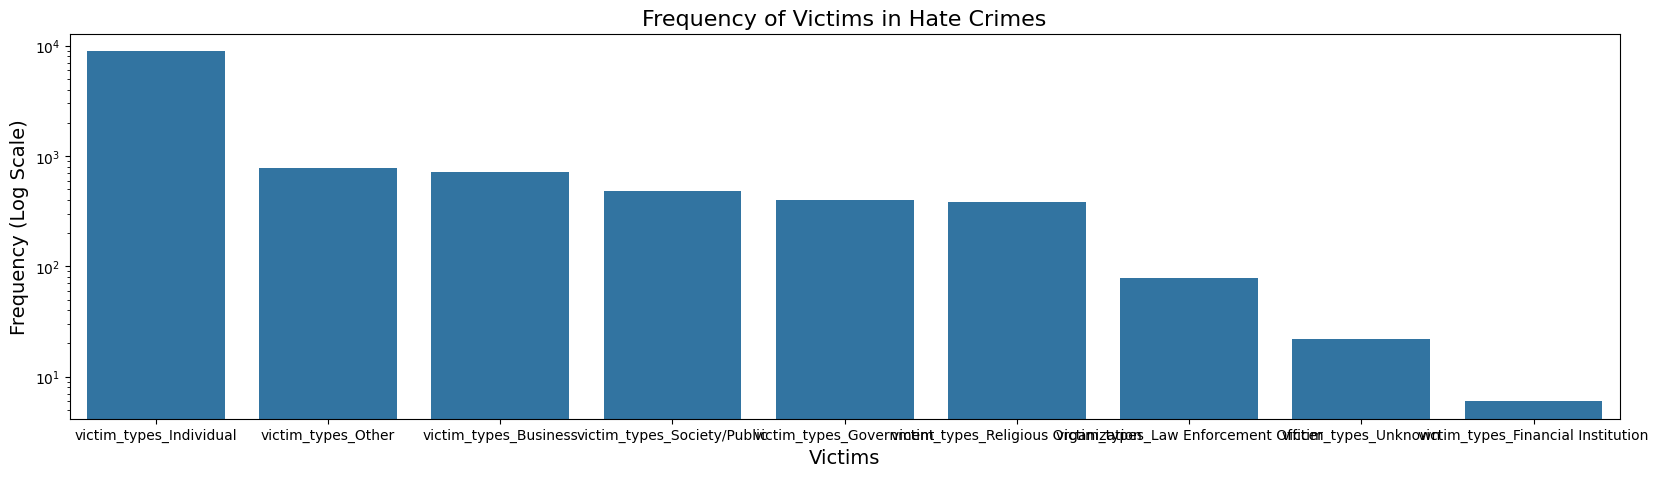

In [109]:
figsize=(20, 5)
plot_column_counts(crime_df, "victim_types", victim_cols, "Victims", figsize, 0)

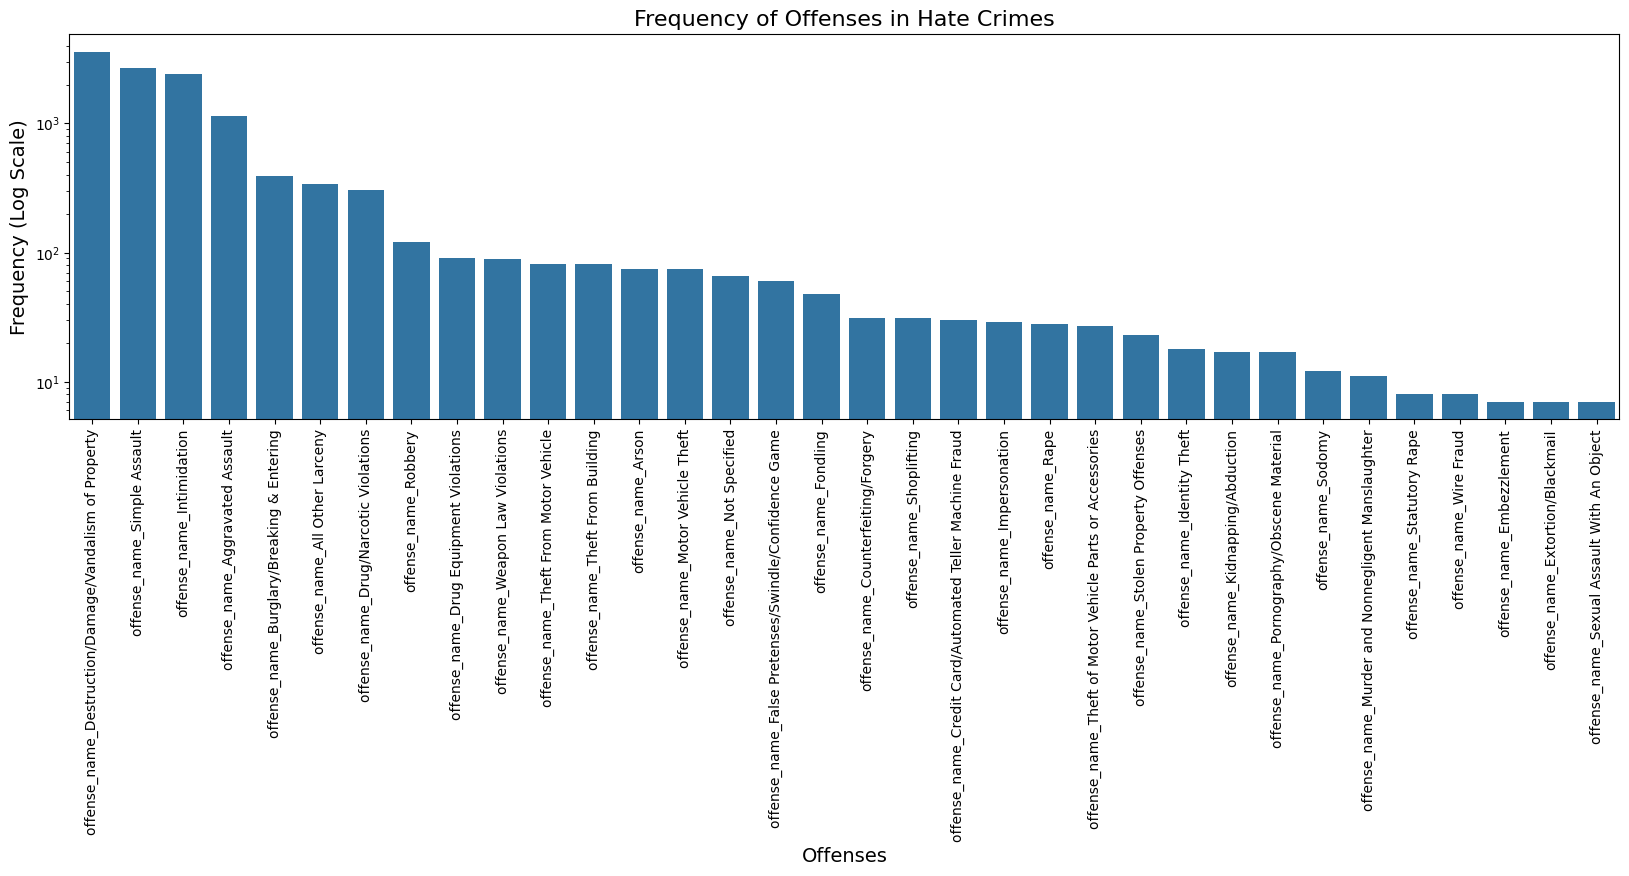

In [110]:
plot_column_counts(crime_df, "offense_name", offense_cols, "Offenses")

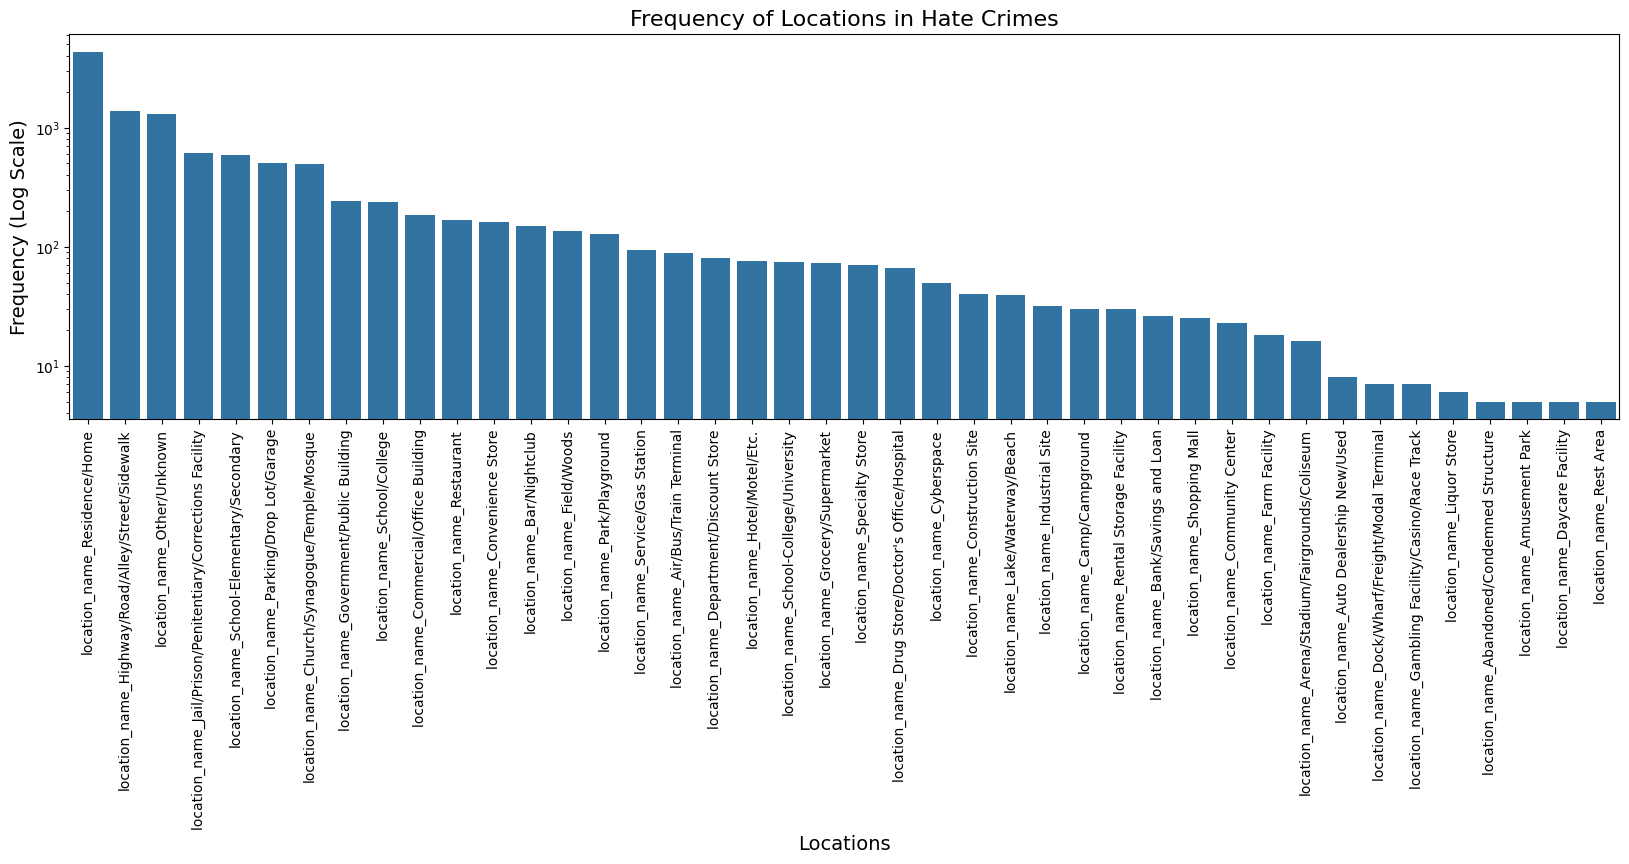

In [111]:
plot_column_counts(crime_df, "location_names", location_cols, "Locations")

####Geographic heat maps

In [112]:
ignore_list = ["Not Specified", "Unknown", "Multiple"]

Text(70.7222222222222, 0.5, 'Offender Race')

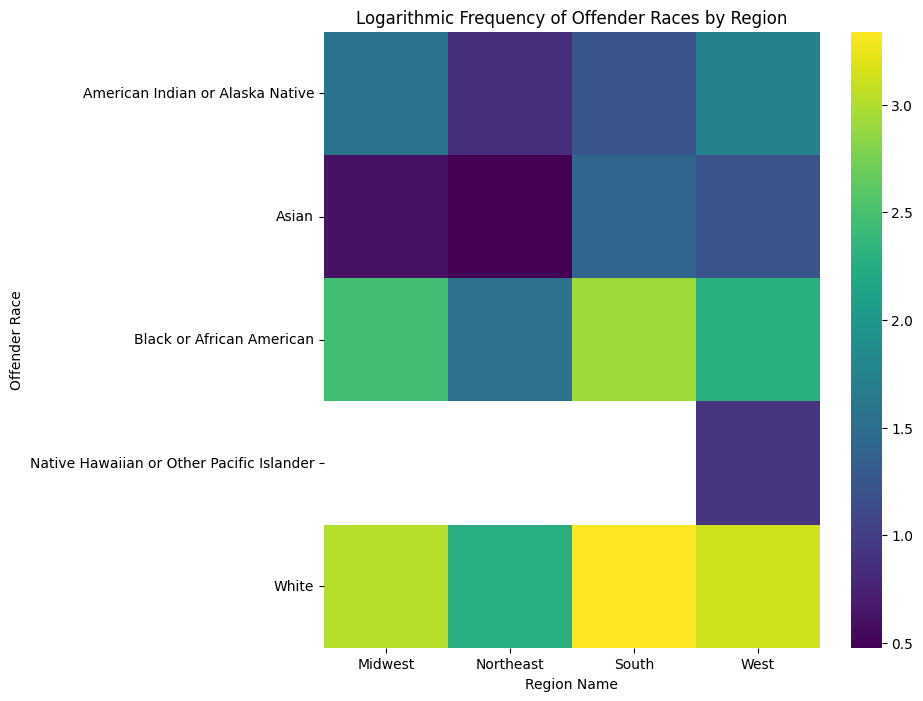

In [113]:
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['offender_race'].value_counts()
    for x_label, grp in crime_df.groupby('region_name')
})

# Drop less relevant columns for easier comparison with victim race heatmap
for item in ignore_list:
  df_2dhist.drop(item, inplace=True)

# Apply logarithmic transformation to the counts
df_2dhist_log = df_2dhist.applymap(lambda x: 0 if x == 0 else np.log10(x))

sns.heatmap(df_2dhist_log, cmap='viridis')
plt.title("Logarithmic Frequency of Offender Races by Region")
plt.xlabel("Region Name")
plt.ylabel("Offender Race")

In [114]:
# Get some victim races to start with
unique_offender_races = crime_df['offender_race'].unique().tolist()

# Drop categories absent from victim data
for item in ignore_list:
  unique_offender_races.remove(item)

unique_victim_races = ["bias_desc_Anti-" + str(race) for race in unique_offender_races]

print(unique_victim_races)

['bias_desc_Anti-White', 'bias_desc_Anti-Black or African American', 'bias_desc_Anti-American Indian or Alaska Native', 'bias_desc_Anti-Asian', 'bias_desc_Anti-Native Hawaiian or Other Pacific Islander']


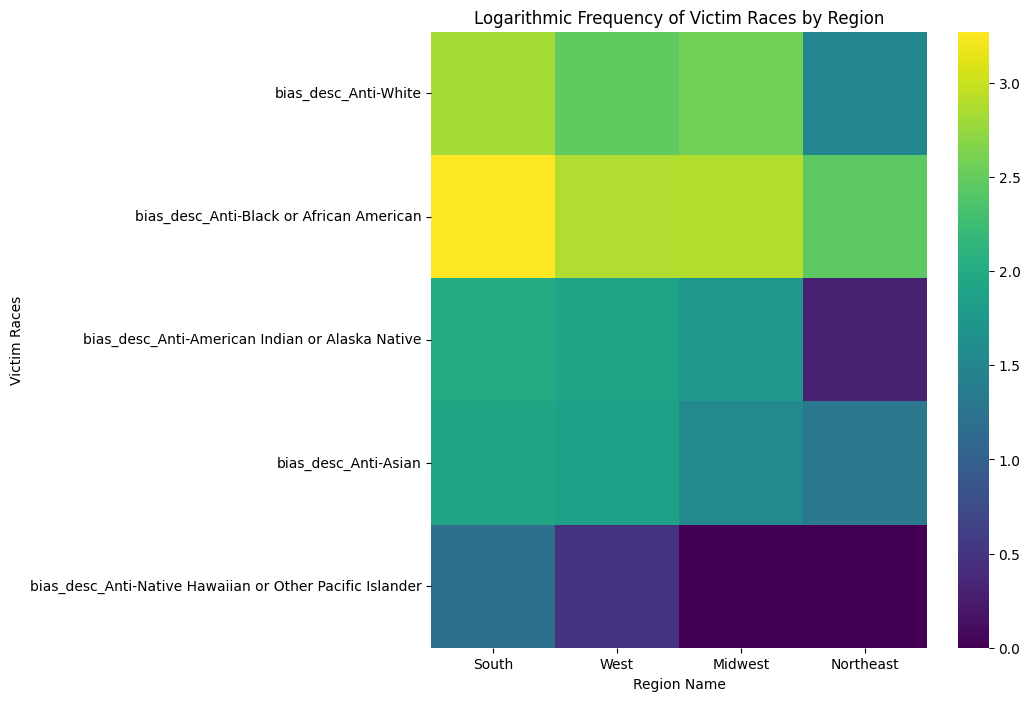

In [115]:
plt.subplots(figsize=(8, 8))

# Initialize an empty DataFrame with the correct index and columns
df_2dhist = pd.DataFrame(index=unique_victim_races, columns=crime_df['region_name'].unique())

# Iterate over each region and calculate the value counts for each victim race
for region in df_2dhist.columns:
    region_data = crime_df[crime_df['region_name'] == region]

    for victim_race in unique_victim_races:
        count = 0
        # Sum of occurrences of victim_race in the region
        if victim_race in region_data.columns:
          count = region_data[victim_race].sum()
        # Update the DataFrame cell with the count
        df_2dhist.loc[victim_race, region] = count

# Convert DataFrame entries to numeric type and drop nan values
df_2dhist = df_2dhist.apply(pd.to_numeric)

# Apply logarithmic transformation to the counts
df_2dhist = df_2dhist.applymap(lambda x: 0 if x == 0 else np.log10(x))

# Create the heatmap with logarithmic scale
sns.heatmap(df_2dhist, cmap='viridis')

# Give the plot a title and axis labels
plt.title("Logarithmic Frequency of Victim Races by Region")
plt.xlabel("Region Name")
plt.ylabel("Victim Races")
plt.yticks(rotation=0)

plt.show()

###County Demographics Dataset

In [116]:
county_df.head()

10 to 14 years  15 to 19 years  18 years and over  20 to 24 years  \
0           12758           11710           141056.0            8429   
1            8536            9051            91549.0            8459   
2            5857            5874            61252.0            4970   
3            5352            4677            52607.0            4965   
4            4996            5009            61212.0            5920   

   21 years and over  25 to 34 years  35 to 44 years  45 to 54 years  \
0           134319.0           21568           23611           27276   
1            84435.0           14368           15170           16674   
2            57688.0            9232            9970           11979   
3            49971.0            9040            9127            9118   
4            58352.0           11214           11255           12308   

   5 to 9 years  55 to 59 years  60 to 64 years  62 years and over  \
0         11338           12278           12579            37328.0   
1          6573            8042            7126            21214.0   
2          4908            5858            4369            14672.0   
3          5352            4596            4091            12393.0   
4          5096            5249            4423            12114.0   

   65 to 74 years  65 years and over  75 to 84 years  85 years and over  \
0           18297            30657.0            9185               3175   
1            9385            17130.0            6093               1652   
2            7243            12625.0            3522               1860   
3            5663             9822.0            3382                777   
4            5468             9208.0            2783                957   

    Female     Geographic Area Name       Geography  \
0  16429.0  Baldwin County, Alabama  0500000US01003   
1  10079.0  Calhoun County, Alabama  0500000US01015   
2   7159.0  Cullman County, Alabama  0500000US01043   
3   5626.0   DeKalb County, Alabama  0500000US01049   
4   5173.0   Elmore County, Alabama  0500000US01051   

   HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)  \
0                                             8078.0               
1                                             3981.0               
2                                             3497.0               
3                                             9622.0               
4                                             2159.0               

   HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Cuban  \
0                                                0.0                      
1                                                0.0                      
2                                                0.0                      
3                                                0.0                      
4                                                0.0                      

   HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Mexican  \
0                                                0.0                        
1                                                0.0                        
2                                                0.0                        
3                                                0.0                        
4                                                0.0                        

   HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Other Hispanic or Latino  \
0                                                0.0                                         
1                                                0.0                                         
2                                                0.0                                         
3                                                0.0                                         
4                                                0.0                                         

   HISPANIC OR LATINO AND RACE!!Hispanic or La

####Correlation matrix

In [117]:
county_numerical_cols = list(county_df.select_dtypes(include=["int64", "float64"]).columns)
county_numerical_cols = [col for col in county_numerical_cols if "transformed_" in col]

In [118]:
# Create a correlation matrix
county_corr = county_df[county_numerical_cols].corr()

In [119]:
# # Set the figure size
# plt.figure(figsize=(100, 50))

# # Create a heatmap of the correlation matrix
# sns.heatmap(county_corr, annot=True)

# # Show the plot
# plt.show()

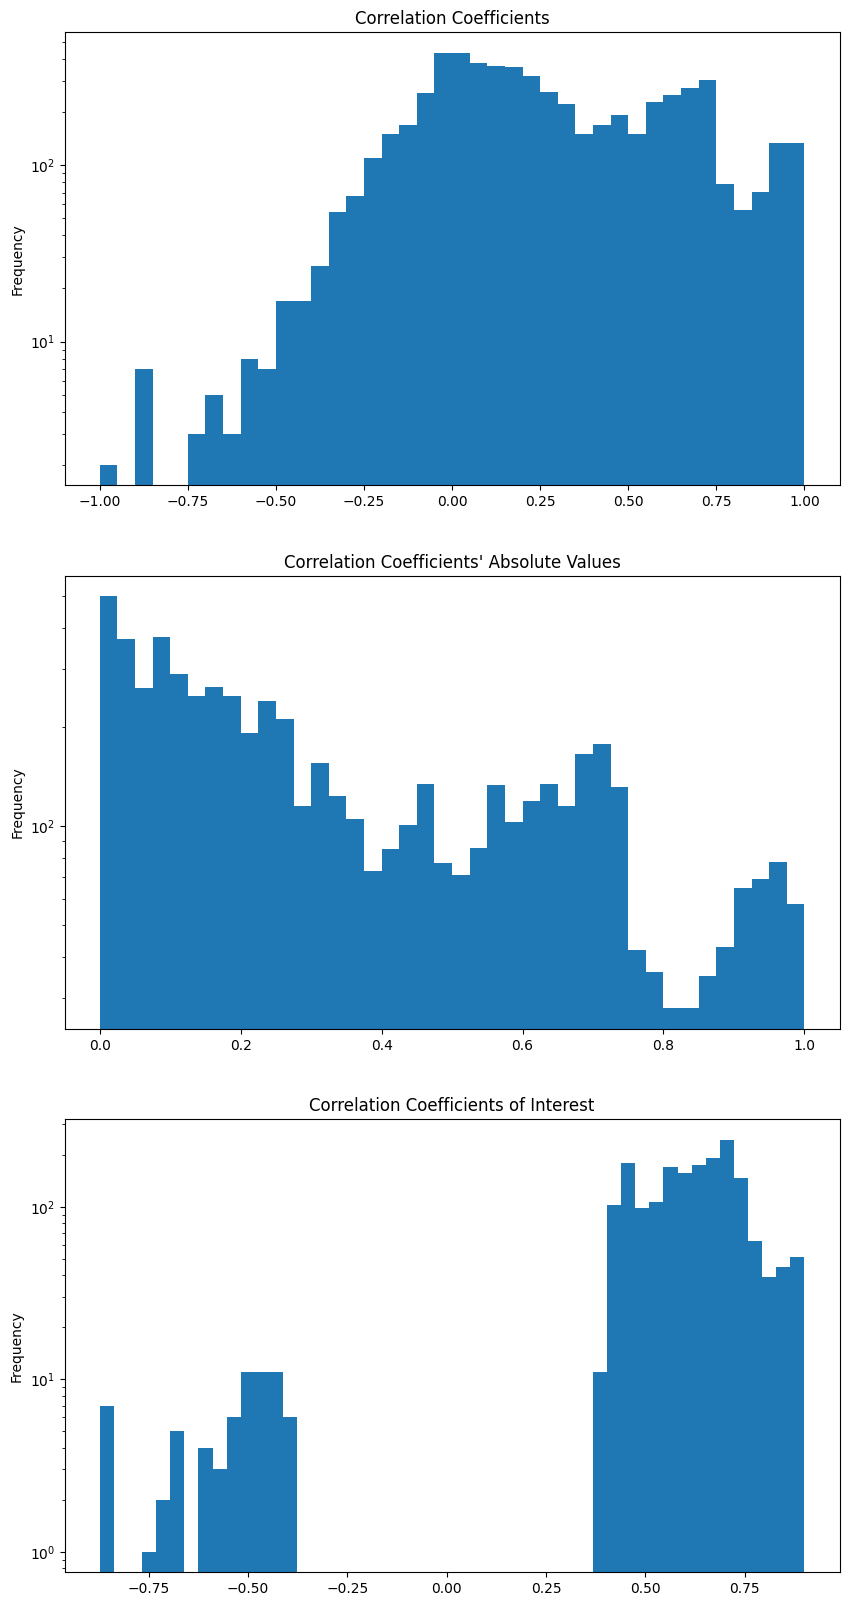

In [120]:
sorted_county_corrs, county_corrs_of_interest = do_corr_analysis(county_corr, 0.4, 0.9, "Geographic Area Name|state_name")

In [121]:
county_corrs_of_interest.reset_index(inplace=True)

In [122]:
county_corrs_of_interest

level_0  index                                           feature1  \
0         649  11445                    transformed_Total housing units   
1         651    554                         transformed_25 to 34 years   
2         653   1740                      transformed_85 years and over   
3         655    434                         transformed_20 to 24 years   
4         657   1424                      transformed_65 years and over   
5         659   2404  transformed_HISPANIC OR LATINO AND RACE!!Not H...   
6         661  11453                    transformed_Total housing units   
7         663    775                         transformed_45 to 54 years   
8         665  11568                       transformed_Total population   
9         667   3066  transformed_HISPANIC OR LATINO AND RACE!!Total...   
10        669   1630                         transformed_75 to 84 years   
11        671   2408  transformed_HISPANIC OR LATINO AND RACE!!Not H...   
12        673   8712  transformed_Percent!!RACE!!One race!!Native Ha...   
13        675   9573  transformed_RACE!!One race!!American Indian an...   
14        677   2749  transformed_HISPANIC OR LATINO AND RACE!!Not H...   
15        679   1088                         transformed_55 to 59 years   
16        681    331                         transformed_20 to 24 years   
17        683   9364                         transformed_RACE!!One race   
18        685    982                         transformed_55 to 59 years   
19        687   1090                         transformed_60 to 64 years   
20        689   2403  transformed_HISPANIC OR LATINO AND RACE!!Not H...   
21        691    996                         transformed_55 to 59 years   
22        693   2012  transformed_HISPANIC OR LATINO AND RACE!!Hispa...   
23        695  10430        transformed_RACE!!One race!!Asian!!Japanese   
24        697   1205                      transformed_62 years and over   
25        699    451                      transformed_21 years and over   
26        701    777                         transformed_45 to 54 years   
27        703   1314                         transformed_65 to 74 years   
28        705   8032  transformed_Percent!!RACE!!One race!!Asian!!Ko...   
29        707   9080              transformed_Percent!!Total population   
30        709   3656             transformed_Percent!!18 years and over   
31        711   3680             transformed_Percent!!18 years and over   
32        713    555                         transformed_25 to 34 years   
33        715   1637                      transformed_85 years and over   
34        717   2968  transformed_HISPANIC OR LATINO AND RACE!!Not H...   
35        719  11685                          transformed_Under 5 years   
36        721    432                         transformed_20 to 24 years   
37        723    131                         transformed_15 to 19 years   
38        725    333                         transformed_20 to 24 years   
39        727    667                         transformed_35 to 44 years   
40        729    875                           transformed_5 to 9 years   
41        731    882                           transformed_5 to 9 years   
42        733   2406  transformed_HISPANIC OR LATINO AND RACE!!Not H...   
43        735   1221                      transformed_62 years and over   
44        737     22                         transformed_10 to 14 years   
45        739   6708            transformed_Percent!!Median age (years)   
46        741   6730            transformed_Percent!!Median age (years)   
47        743   6732            transformed_Percent!!Median age (years)   
48        745   9019           transformed_Percent!!Total housing units   
49        747   6513  transformed_Percent!!HISPANIC OR LATINO AND RA...   
50        749   8911        transformed_Percent!!RACE!!Total population   
51        751   1091                         transformed_60 to 64 years   
52        753   9437  transform

####Scatter Plots

In [123]:
# create a scatter plot for every feature pair in case there's one of interest
for i in range(len(county_corrs_of_interest)):
    row = county_corrs_of_interest.iloc[i]
    # county_df.plot.scatter(x=row["feature1"], y=row["feature2"])

####Other figures

<Axes: xlabel='Under 5 years', ylabel='85 years and over'>

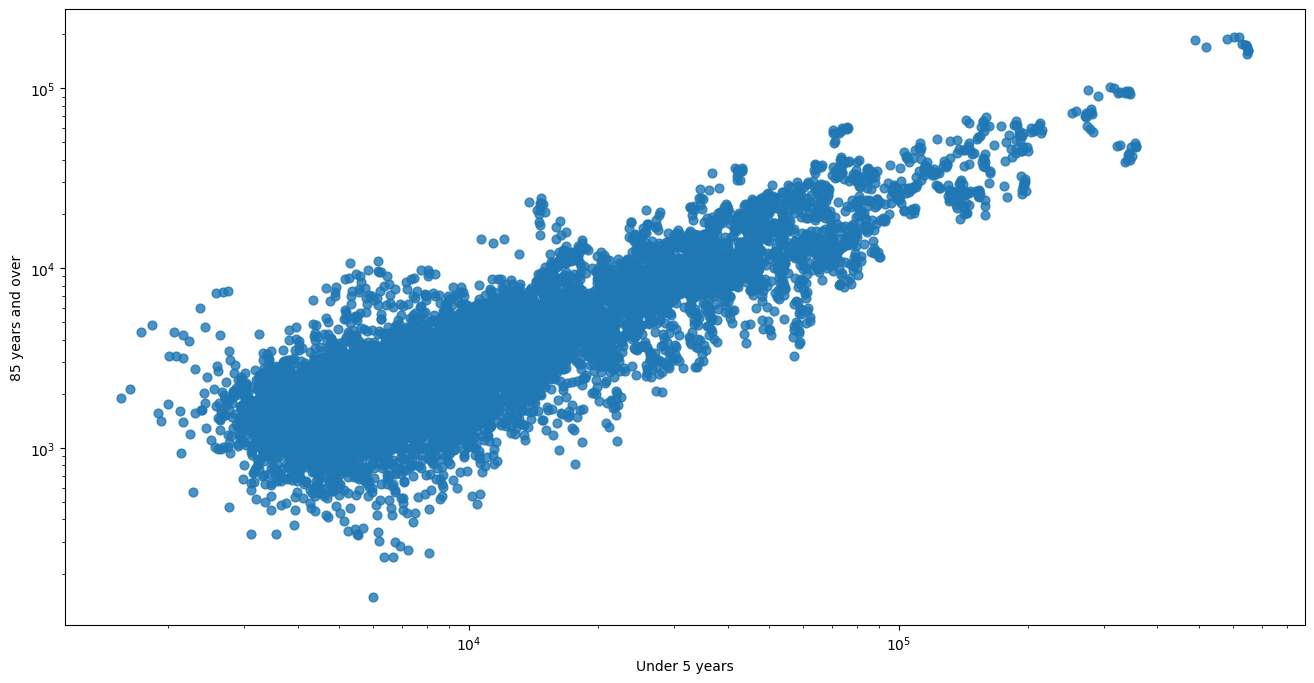

In [124]:
county_df.plot.scatter(x='Under 5 years', y='85 years and over', logx=True, logy=True, s=40, alpha=.5, figsize=(16,8))

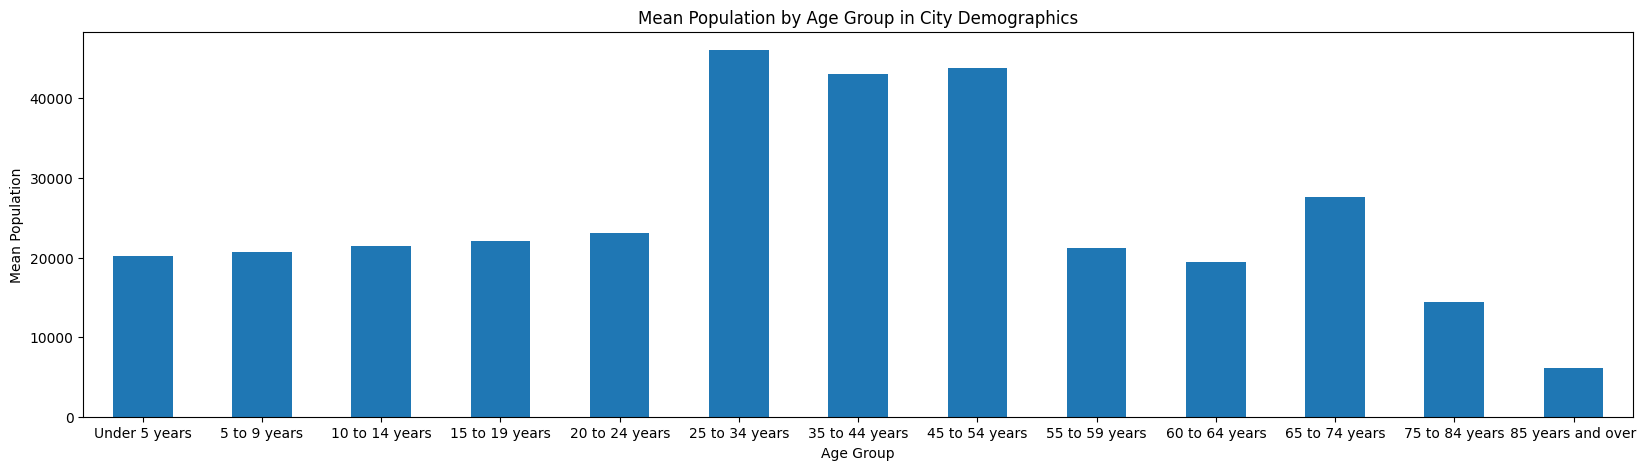

In [125]:
county_df[age_groups].mean().plot.bar(figsize=(20,5))
plt.xlabel('Age Group')
plt.ylabel('Mean Population')
plt.title('Mean Population by Age Group in City Demographics')
plt.xticks(rotation=0)
plt.show()

##Merged Datasets

###Primary Merged Dataset

In [126]:
merged_df.head()

incident_id  data_year region_name  adult_victim_count  \
0       143590       2010       South                 NaN   
1       143591       2010       South                 NaN   
2       143592       2010       South                 NaN   
3       143593       2010       South                 NaN   
4       143594       2010       South                 NaN   

   juvenile_victim_count  total_offender_count  adult_offender_count  \
0                    NaN                     1                   NaN   
1                    NaN                     1                   NaN   
2                    NaN                     1                   NaN   
3                    NaN                     0                   NaN   
4                    NaN                     1                   NaN   

   juvenile_offender_count  victim_count    offense_name  \
0                      NaN             1    Intimidation   
1                      NaN             1  Simple Assault   
2                      NaN             1  Simple Assault   
3                      NaN             1    Intimidation   
4                      NaN             1  Simple Assault   

   total_individual_victims  incident_month  incident_day  \
0                       1.0               9             1   
1                       1.0               6            16   
2                       1.0               6            16   
3                       1.0               4             5   
4                       1.0               4             2   

   bias_desc_Anti-American Indian or Alaska Native  bias_desc_Anti-Arab  \
0                                                0                    0   
1                                                0                    0   
2                                                0                    0   
3                                                0                    0   
4                                                0                    0   

   bias_desc_Anti-Asian  bias_desc_Anti-Atheism/Agnosticism  \
0                     0                                   0   
1                     0                                   0   
2                     0                                   0   
3                     0                                   0   
4                     0                                   0   

   bias_desc_Anti-Bisexual  bias_desc_Anti-Black or African American  \
0                        0                                         1   
1                        0                                         0   
2                        0                                         1   
3                        0                                         1   
4                        0                                         1   

   bias_desc_Anti-Buddhist  bias_desc_Anti-Catholic  \
0                        0                        0   
1                        0                        0   
2                        0                        0   
3                        0                        0   
4                        0                        0   

   bias_desc_Anti-Church of Jesus Christ  \
0                                      0   
1                                      0   
2                                      0   
3                                      0   
4                                      0   

   bias_desc_Anti-Eastern Orthodox (Russian, Greek, Other)  \
0                                                  0         
1                                                  0         
2                                                  0         
3                                                  0         
4                                                  0         

   bias_desc_Anti-Female  bias_desc_Anti-Gay (Male)  \
0                      0                          0   
1                      0                          0   
2                      0                          0   
3                      

####Correlation Matrix Analysis

In [127]:
#convert the categorical columns to numerical ones and store the modified df as a new df for correlation analysis
categorical_to_int_df = merged_df\
                          .select_dtypes(include=['int64', 'float64', np.number])\
                          .drop(labels=["incident_id"], axis=1)
# Select only the numerical columns
numerical_cols = [col for col in categorical_to_int_df.columns if "transformed_" in col]
# numerical_cols

In [128]:
# Create a correlation matrix
merged_corr = merged_df[numerical_cols].corr()

In [129]:
merged_corr_sorted = get_sorted_corrs(merged_corr)
merged_corr_sorted.head()

index                                           feature1  \
5     4795  transformed_HISPANIC OR LATINO AND RACE!!Total...   
89   13839                 transformed_RACE!!Total population   
93   14079                       transformed_Total population   
97   11372              transformed_Percent!!Total population   
104   8492  transformed_Percent!!HISPANIC OR LATINO AND RA...   

                                              feature2  corr  abs_corr  
5                   transformed_RACE!!Total population   1.0       1.0  
89   transformed_HISPANIC OR LATINO AND RACE!!Total...   1.0       1.0  
93   transformed_HISPANIC OR LATINO AND RACE!!Total...   1.0       1.0  
97         transformed_Percent!!RACE!!Total population   1.0       1.0  
104        transformed_Percent!!RACE!!Total population   1.0       1.0

In [130]:
# remove coefficients that represent variables' correlations with themselves
#   and remove feature correlations with other features from the same set (which were reviewed in the individual dataset explorations above)
county_cols = list(county_numerical_cols)
crime_cols = list(crime_numerical_cols)

merged_corr_sorted = merged_corr_sorted[~(
    ((merged_corr_sorted["feature1"].isin(county_cols))
      & (merged_corr_sorted["feature2"].isin(county_cols)))
    | ((merged_corr_sorted["feature1"].isin(crime_cols))
      & (merged_corr_sorted["feature2"].isin(crime_cols)))
)]

In [131]:
merged_corr_sorted.head()

index                     feature1                 feature2      corr  \
138     239      transformed_data_year_x  transformed_data_year_y  0.999184   
892     119      transformed_incident_id  transformed_data_year_y  0.894270   
958     120      transformed_data_year_x  transformed_incident_id  0.881404   
3316   8520    transformed_Percent!!Male  transformed_incident_id  0.639750   
3318   6960  transformed_Percent!!Female  transformed_incident_id -0.639742   

      abs_corr  
138   0.999184  
892   0.894270  
958   0.881404  
3316  0.639750  
3318  0.639742

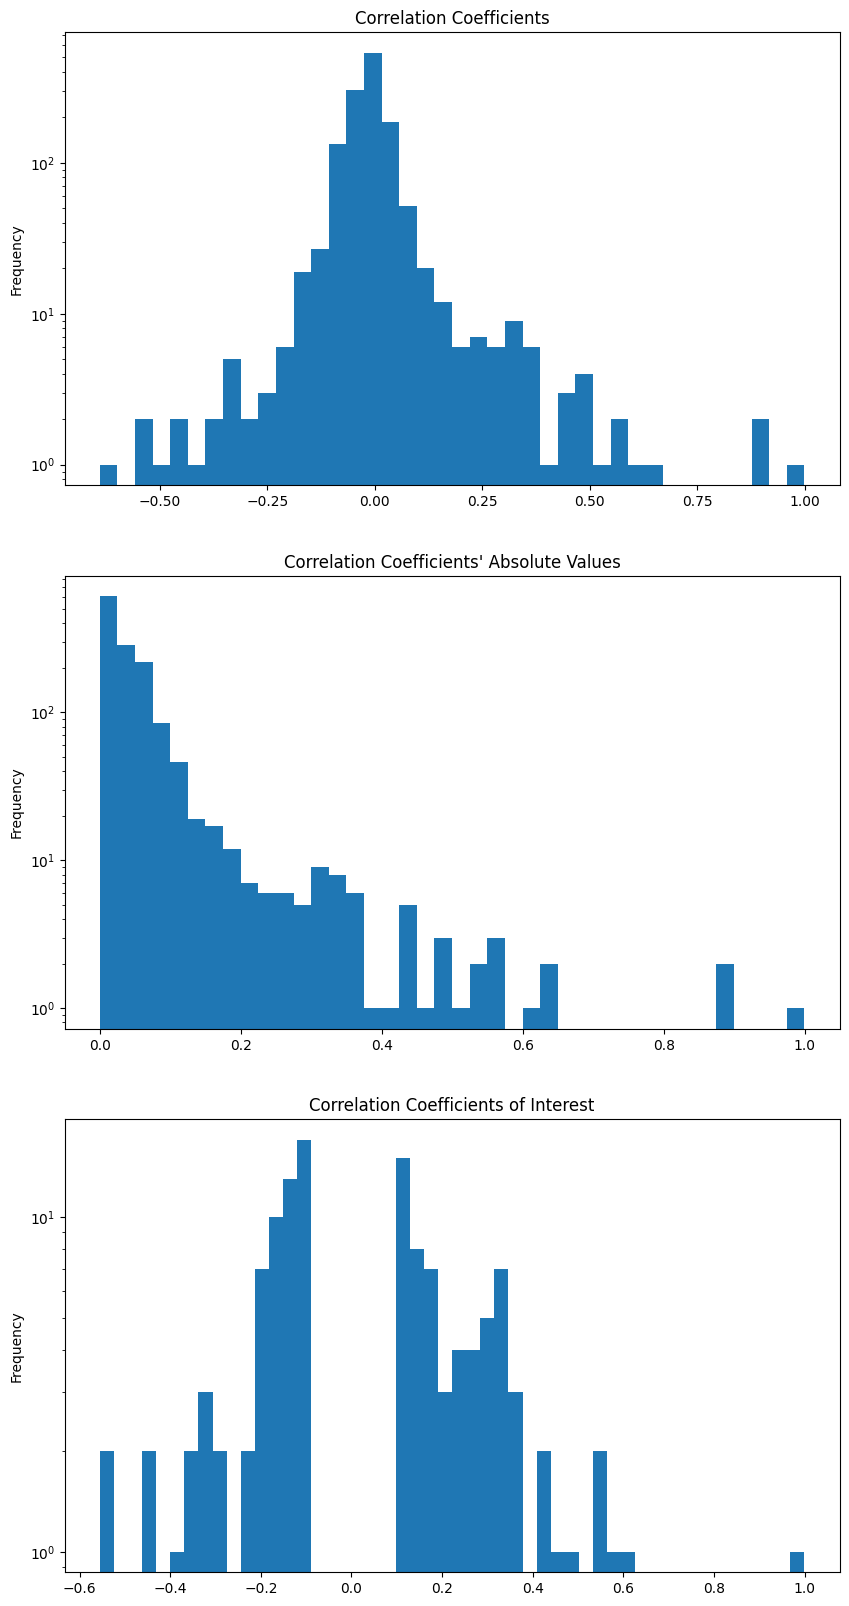

In [132]:
# drop half the entries, which are essentially duplicates,
#   as well as any np.nan entries and entries with low correlation coefficients or exceedingly high correlation coefficients,
#   which have already been considered previously or present trivial correlation information
#   (ie the number of individuals under 5 years of age is directly correlated with the total population)
merged_corr_sorted, merged_corrs_of_interest = do_corr_analysis(merged_corr, 0.1, 1, "state_name|division_name|Geographic Area Name|index|incident_id", merged_corr_sorted)

In [133]:
merged_corrs_of_interest

index                                           feature1  \
138     239                            transformed_data_year_x   
3498    602                   transformed_adult_offender_count   
4098    723                transformed_juvenile_offender_count   
4250  14351                            transformed_data_year_y   
4252   7079                        transformed_Percent!!Female   
4382    191                            transformed_data_year_x   
4386   6961                        transformed_Percent!!Female   
4986    962               transformed_total_individual_victims   
5166  14329                            transformed_data_year_y   
5234   6599                transformed_Percent!!65 to 74 years   
5260    169                            transformed_data_year_x   
5268    604                   transformed_adult_offender_count   
5314    174                            transformed_data_year_x   
5862  14285                            transformed_data_year_y   
5894  14353                            transformed_data_year_y   
5944   8761                transformed_Percent!!RACE!!One race   
6108  14320                            transformed_data_year_y   
6164    601                   transformed_adult_offender_count   
6188    654                   transformed_adult_offender_count   
6196    160                            transformed_data_year_x   
6198   5885                transformed_Percent!!45 to 54 years   
6310  14333                            transformed_data_year_y   
6332  14282                            transformed_data_year_y   
6372   6361             transformed_Percent!!62 years and over   
6468    298                     transformed_adult_victim_count   
6470   8522                          transformed_Percent!!Male   
6484  11519                 transformed_Percent!!Under 5 years   
6490   3359                                 transformed_Female   
6544    215                            transformed_data_year_x   
6592   3241                                 transformed_Female   
6642    241                     transformed_adult_victim_count   
6726   5882                transformed_Percent!!45 to 54 years   
6842    658                   transformed_adult_offender_count   
6844    671                   transformed_adult_offender_count   
6852   5639             transformed_Percent!!21 years and over   
6932    166                            transformed_data_year_x   
7112    294                     transformed_adult_victim_count   
7398    967               transformed_total_individual_victims   
7480    653                   transformed_adult_offender_count   
7504   6839                transformed_Percent!!75 to 84 years   
7528   6721                transformed_Percent!!75 to 84 years   
7716    247                     transformed_adult_victim_count   
7762  14332                            transformed_data_year_y   
7780    243                     transformed_adult_victim_count   
7814    172                            transformed_data_year_x   
7962    606                   transformed_adult_offender_count   
8090   5279                transformed_Percent!!15 to 19 years   
8102    673                   transformed_adult_offender_count   
8130  14330                            transformed_data_year_y   
8158   5161                transformed_Percent!!15 to 19 years   
8162    646                   transformed_adult_offender_count   
8196   6001                  transformed_Percent!!5 to 9 years   
8340    964               transformed_total_individual_victims   
8346    656                   transformed_adult_offender_count   
8374    313                     transformed_adult_victim_count   
8386    293                     transformed_adult_victim_count   
8432    643                   transformed_adult_offender_count   
8472  14286                            transformed_data_year_y   
8482  11045        transformed_Percent!!RACE!!Total population   
8484   8405  transformed_Percent!!HISPANIC OR 

####Other Figures

<Axes: xlabel='transformed_Percent!!RACE!!One race!!White', ylabel='transformed_Percent!!45 to 54 years'>

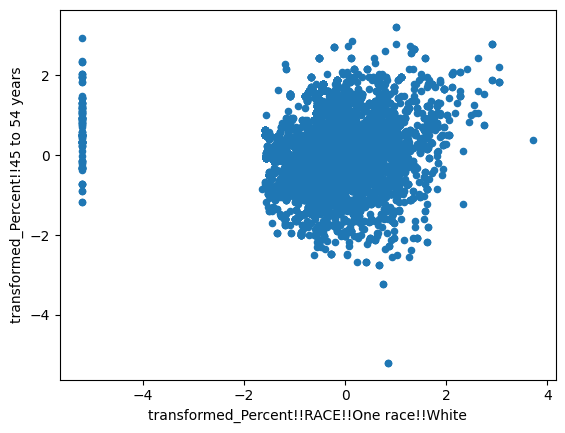

In [134]:
merged_df.plot.scatter(x="transformed_Percent!!RACE!!One race!!White", y="transformed_Percent!!45 to 54 years")

###County Feature Prediction Dataset

In [135]:
county_hate_rates_df["transformed_data_year"].unique()  #.head()

array([-5.19933758, -1.15995015, -0.82210608, -0.55840941, -0.32865877,
       -0.11497783,  0.0940271 ,  0.30792789,  0.53827736,  0.80237944,
        1.14049263,  5.19933758])

In [136]:
county_hate_rates_df.head()

hate_crime_count  hate_crime_count  transformed_10 to 14 years  \
0                17                17                   -0.074124   
1                17                17                   -0.091128   
2                17                17                   -0.034274   
3                17                17                   -0.289291   
4                17                17                   -0.108031   

   transformed_15 to 19 years  transformed_18 years and over  \
0                   -0.116115                      -0.194136   
1                   -0.106895                      -0.190045   
2                   -0.267111                      -0.195160   
3                   -0.255940                      -0.189023   
4                   -0.288506                      -0.188000   

   transformed_20 to 24 years  transformed_21 years and over  \
0                   -0.311879                      -0.193113   
1                   -0.312933                      -0.183403   
2                   -0.272057                      -0.176769   
3                   -0.211177                      -0.171672   
4                   -0.208996                      -0.170653   

   transformed_25 to 34 years  transformed_35 to 44 years  \
0                   -0.240407                   -0.145994   
1                   -0.228795                   -0.184169   
2                   -0.212717                   -0.169125   
3                   -0.301091                   -0.126990   
4                   -0.256718                   -0.177279   

   transformed_45 to 54 years  transformed_5 to 9 years  \
0                   -0.058777                 -0.126737   
1                   -0.055382                 -0.203226   
2                   -0.145233                 -0.208611   
3                   -0.155897                  0.045579   
4                   -0.146882                 -0.243767   

   transformed_55 to 59 years  transformed_60 to 64 years  \
0                   -0.097936                   -0.195799   
1                   -0.269843                    0.004770   
2                   -0.034022                   -0.128255   
3                    0.092640                   -0.447129   
4                   -0.175495                    0.002385   

   transformed_62 years and over  transformed_65 to 74 years  \
0                      -0.226991                   -0.391344   
1                      -0.162762                   -0.322174   
2                      -0.158693                   -0.294531   
3                      -0.182893                   -0.171417   
4                      -0.113083                   -0.145487   

   transformed_65 years and over  transformed_75 to 84 years  \
0                      -0.206430                   -0.031636   
1                      -0.185063                   -0.041559   
2                      -0.161236                   -0.178682   
3                      -0.104749                   -0.110557   
4                      -0.107274                   -0.129521   

   transformed_85 years and over  transformed_Female  \
0                      -0.010795           -1.178599   
1                      -0.025232           -1.155289   
2                       0.250626           -1.156268   
3                       0.153102            0.152594   
4                       0.092892            0.140668   

   transformed_HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)  \
0                                          -0.436887                           
1                                          -0.428341                           
2                                          -0.428341                           
3                                          -0.422296                           
4                                          -0.406703                           

   transformed_HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Cuban  \
0                                          -5.199338  

####Correlation Analysis

In [137]:
hate_rate_corr = county_hate_rates_df[hate_rate_numerical_cols].corr()

In [138]:
hate_rate_corr.head()

hate_crime_count  hate_crime_count  \
hate_crime_count                    1.000000          1.000000   
hate_crime_count                    1.000000          1.000000   
hate_crime_count                    1.000000          1.000000   
hate_crime_count                    1.000000          1.000000   
transformed_10 to 14 years          0.355525          0.355525   

                            hate_crime_count  hate_crime_count  \
hate_crime_count                    1.000000          1.000000   
hate_crime_count                    1.000000          1.000000   
hate_crime_count                    1.000000          1.000000   
hate_crime_count                    1.000000          1.000000   
transformed_10 to 14 years          0.355525          0.355525   

                            transformed_10 to 14 years  \
hate_crime_count                              0.355525   
hate_crime_count                              0.355525   
hate_crime_count                              0.355525   
hate_crime_count                              0.355525   
transformed_10 to 14 years                    1.000000   

                            transformed_15 to 19 years  \
hate_crime_count                              0.354452   
hate_crime_count                              0.354452   
hate_crime_count                              0.354452   
hate_crime_count                              0.354452   
transformed_10 to 14 years                    0.943362   

                            transformed_18 years and over  \
hate_crime_count                                 0.359324   
hate_crime_count                                 0.359324   
hate_crime_count                                 0.359324   
hate_crime_count                                 0.359324   
transformed_10 to 14 years                       0.937559   

                            transformed_20 to 24 years  \
hate_crime_count                              0.350636   
hate_crime_count                              0.350636   
hate_crime_count                              0.350636   
hate_crime_count                              0.350636   
transformed_10 to 14 years                    0.893772   

                            transformed_21 years and over  \
hate_crime_count                                 0.359269   
hate_crime_count                                 0.359269   
hate_crime_count                                 0.359269   
hate_crime_count                                 0.359269   
transformed_10 to 14 years                       0.942891   

                            transformed_25 to 34 years  \
hate_crime_count                              0.351384   
hate_crime_count                              0.351384   
hate_crime_count                              0.351384   
hate_crime_count                              0.351384   
transformed_10 to 14 years                    0.944795   

                            transformed_35 to 44 years  \
hate_crime_count                              0.357170   
hate_crime_count                              0.357170   
hate_crime_count                              0.357170   
hate_crime_count                              0.357170   
transformed_10 to 14 years                    0.974338   

                            transformed_45 to 54 years  \
hate_crime_count                              0.361657   
hate_crime_count                              0.361657   
hate_crime_count                              0.361657   
hate_crime_count                              0.361657   
transformed_10 to 14 years                    0.960375   

                            transformed_5 to 9 years  \
hate_crime_count                            0.355539   
hate_crime_count                            0.355539   
hate_crime_count                            0.355539   
hate_crime_count                            0.355539   
transformed_10 to 14 years                  0.960749   

                            transformed_55 to 59 years  \
hate_crime_

In [139]:
# # Set the figure size
# plt.figure(figsize=(100, 50))

# # Create a heatmap of the correlation matrix
# sns.heatmap(hate_rate_corr, annot=True)

# # Show the plot
# plt.show()

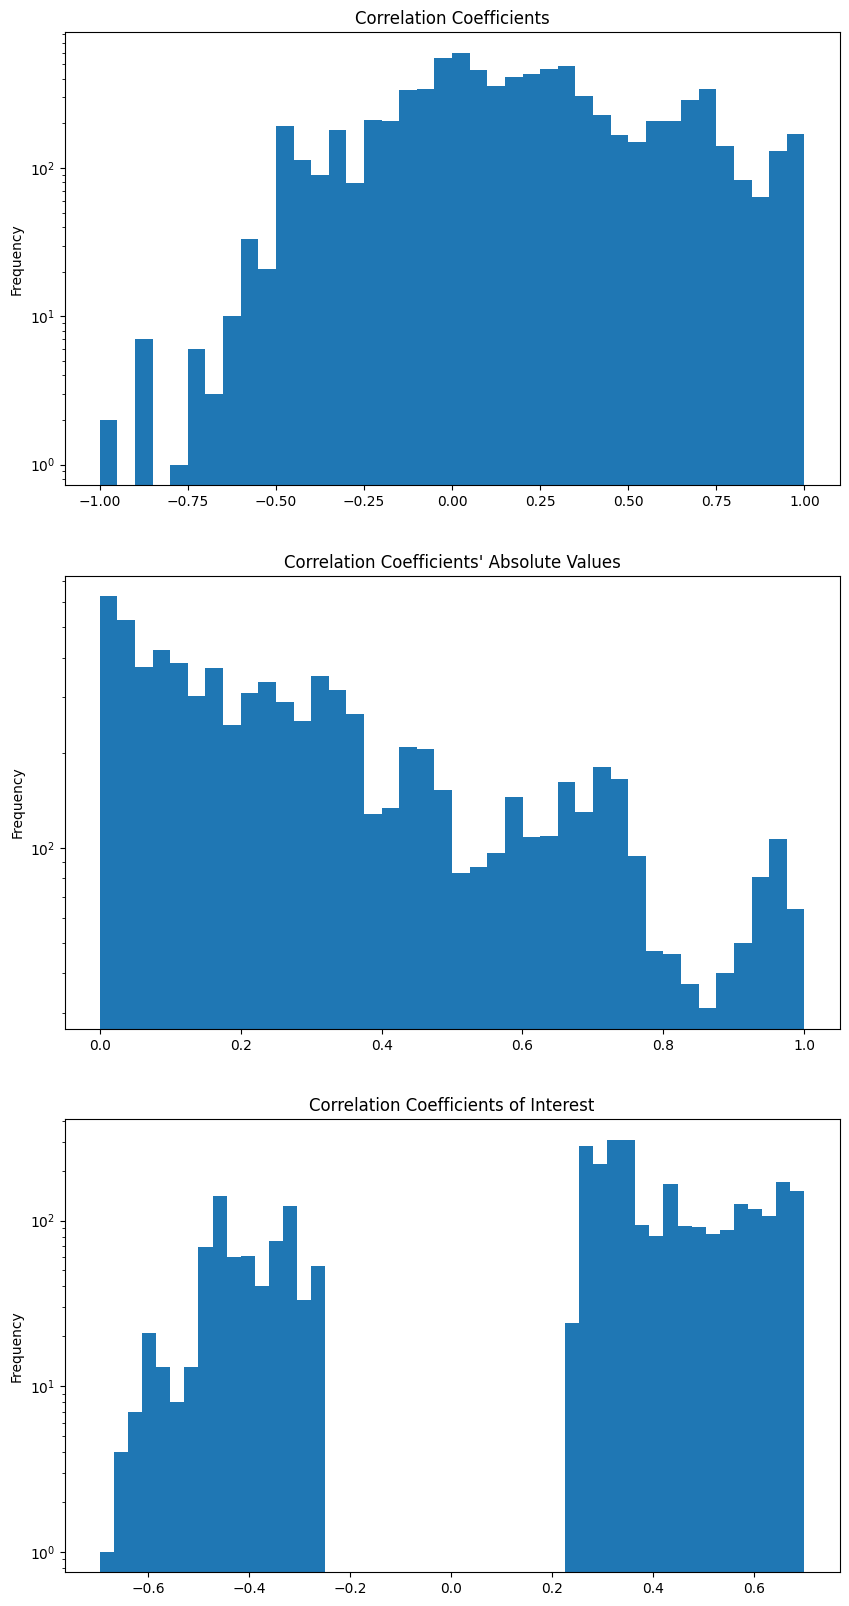

In [149]:
# hate_rate_corr.set_index(["state_name", "division_name", "Geographic Area Name"], inplace=True)
extracted_sorted_corrs, extracted_corrs_of_interest = do_corr_analysis(hate_rate_corr, 0.25, 0.7, "state_name|division_name|Geographic Area Name")

In [150]:
# look at just the correlations between the hate crime rate and other features
hate_rate_corrs_of_interest = extracted_corrs_of_interest\
                                [(extracted_corrs_of_interest["feature1"] == "transformed_hate_crime_rate")\
                                  | (extracted_corrs_of_interest["feature2"] == "transformed_hate_crime_rate")]\
                                .sort_values(ascending=False, by="abs_corr")\
                                .dropna()\
                                .reset_index()

In [151]:
hate_rate_corrs_of_interest

level_0  index                                           feature1  \
0      2932  15110                        transformed_hate_crime_rate   
1      2946  15214                        transformed_hate_crime_rate   
2      2948  15212                        transformed_hate_crime_rate   
3      2950  15136                        transformed_hate_crime_rate   
4      2992  15112                        transformed_hate_crime_rate   
5      3024  15213                        transformed_hate_crime_rate   
6      3156  15117                        transformed_hate_crime_rate   
7      3166   1270                         transformed_25 to 34 years   
8      3172   1526                         transformed_45 to 54 years   
9      3190   1398                         transformed_35 to 44 years   
10     3204    758                         transformed_15 to 19 years   
11     3214  14326                          transformed_Under 5 years   
12     3246   1654                           transformed_5 to 9 years   
13     3264   2038                      transformed_62 years and over   
14     3278  15118                        transformed_hate_crime_rate   
15     3288   2294                      transformed_65 years and over   
16     3298  15130                        transformed_hate_crime_rate   
17     3304   2422                         transformed_75 to 84 years   
18     3336  15120                        transformed_hate_crime_rate   
19     3348   1014                         transformed_20 to 24 years   
20     3350  15108                        transformed_hate_crime_rate   
21     3480   2550                      transformed_85 years and over   
22     3728   2806  transformed_HISPANIC OR LATINO AND RACE!!Hispa...   
23     3794  11510                         transformed_RACE!!One race   
24     3870  15211                        transformed_hate_crime_rate   
25     3944   3190  transformed_HISPANIC OR LATINO AND RACE!!Hispa...   
26     3968  15129                        transformed_hate_crime_rate   
27     3992  15126                        transformed_hate_crime_rate   
28     3994  15127                        transformed_hate_crime_rate   
29     4284   7158  transformed_Percent!!HISPANIC OR LATINO AND RA...   
30     4288  15124                        transformed_hate_crime_rate   
31     4292  15135                        transformed_hate_crime_rate   
32     4360  15158                        transformed_hate_crime_rate   
33     4368  15199                        transformed_hate_crime_rate   
34     4370   7286  transformed_Percent!!HISPANIC OR LATINO AND RA...   
35     4374  15141                        transformed_hate_crime_rate   
36     4452  13046     transformed_RACE!!One race!!Asian!!Other Asian   
37     4514  13174      transformed_RACE!!One race!!Asian!!Vietnamese   
38     4524  15202                        transformed_hate_crime_rate   
39     4550  12406    transformed_RACE!!One race!!Asian!!Asian Indian   
40     4568  12534         transformed_RACE!!One race!!Asian!!Chinese   
41     4588   4342                                   transformed_Male   
42     4616   3702  transformed_HISPANIC OR LATINO AND RACE!!Not H...   
43     4756   6262             transformed_Percent!!65 years and over   
44     4776  12918          transformed_RACE!!One race!!Asian!!Korean   
45     4806  15203                        transformed_hate_crime_rate   
46     4820  13302  transformed_RACE!!One race!!Black or African A...   
47     4854  15182                        transformed_hate_crime_rate   
48     4922  15177                        transformed_hate_crime_rate   
49     4924  15179                        transformed_hate_crime_rate   
50     4960   9590  transformed_Percent!!RACE!!One race!!Asian!!Ch...   
51     4970  15157                        transformed_hate_crime_rate   
52     4988  10230  transformed_Percent!!RACE!!One race!!Asian!!Vi...   
53     5022   3830  transformed_HISPANIC OR LATINO AND RACE!!N

<Axes: title={'center': 'Hate Crime Rate Correlation Coefficient Frequencies'}, ylabel='Frequency'>

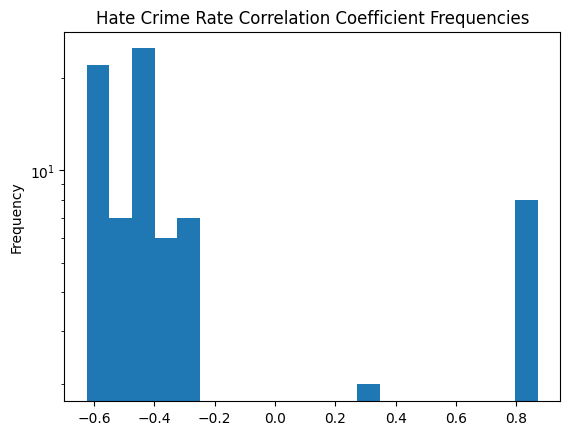

In [148]:
hate_rate_corrs_of_interest['corr'].plot.hist(bins=20, title='Hate Crime Rate Correlation Coefficient Frequencies', logy=True)

####Scatter Plots

In [161]:
hate_rate_features = sorted(set(hate_rate_corrs_of_interest["feature1"].unique())\
                              .union(set(hate_rate_corrs_of_interest["feature2"].unique())))

In [203]:
for feature in hate_rate_features:
  print(feature)

  county_hate_rates_df.plot.scatter(
    x=feature,
    y="transformed_hate_crime_rate",
    c=county_hate_rates_df["data_year"],
    cmap='viridis',
    colorbar=True
  )

transformed_10 to 14 years


KeyError: 'data_year'

#Data Prediction

In [163]:
# hate_rate_numerical_cols

['hate_crime_count',
 'transformed_10 to 14 years',
 'transformed_15 to 19 years',
 'transformed_18 years and over',
 'transformed_20 to 24 years',
 'transformed_21 years and over',
 'transformed_25 to 34 years',
 'transformed_35 to 44 years',
 'transformed_45 to 54 years',
 'transformed_5 to 9 years',
 'transformed_55 to 59 years',
 'transformed_60 to 64 years',
 'transformed_62 years and over',
 'transformed_65 to 74 years',
 'transformed_65 years and over',
 'transformed_75 to 84 years',
 'transformed_85 years and over',
 'transformed_Female',
 'transformed_HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)',
 'transformed_HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Cuban',
 'transformed_HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Mexican',
 'transformed_HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Other Hispanic or Latino',
 'transformed_HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Puerto Rican',
 

In [164]:
# designate the training data
training_cols = [col for col in hate_rate_numerical_cols if (not "hate_crime_rate" in col) and ("transformed_" in col) and col in county_hate_rates_df.columns]
x_train_df = county_hate_rates_df[training_cols]
y_train_df = county_hate_rates_df["transformed_hate_crime_rate"]
x_train_df.dropna(inplace=True)
y_train_df.dropna(inplace=True)

In [165]:
x_train_df.head()

transformed_10 to 14 years  transformed_15 to 19 years  \
0                   -0.074124                   -0.116115   
1                   -0.091128                   -0.106895   
2                   -0.034274                   -0.267111   
3                   -0.289291                   -0.255940   
4                   -0.108031                   -0.288506   

   transformed_18 years and over  transformed_20 to 24 years  \
0                      -0.194136                   -0.311879   
1                      -0.190045                   -0.312933   
2                      -0.195160                   -0.272057   
3                      -0.189023                   -0.211177   
4                      -0.188000                   -0.208996   

   transformed_21 years and over  transformed_25 to 34 years  \
0                      -0.193113                   -0.240407   
1                      -0.183403                   -0.228795   
2                      -0.176769                   -0.212717   
3                      -0.171672                   -0.301091   
4                      -0.170653                   -0.256718   

   transformed_35 to 44 years  transformed_45 to 54 years  \
0                   -0.145994                   -0.058777   
1                   -0.184169                   -0.055382   
2                   -0.169125                   -0.145233   
3                   -0.126990                   -0.155897   
4                   -0.177279                   -0.146882   

   transformed_5 to 9 years  transformed_55 to 59 years  \
0                 -0.126737                   -0.097936   
1                 -0.203226                   -0.269843   
2                 -0.208611                   -0.034022   
3                  0.045579                    0.092640   
4                 -0.243767                   -0.175495   

   transformed_60 to 64 years  transformed_62 years and over  \
0                   -0.195799                      -0.226991   
1                    0.004770                      -0.162762   
2                   -0.128255                      -0.158693   
3                   -0.447129                      -0.182893   
4                    0.002385                      -0.113083   

   transformed_65 to 74 years  transformed_65 years and over  \
0                   -0.391344                      -0.206430   
1                   -0.322174                      -0.185063   
2                   -0.294531                      -0.161236   
3                   -0.171417                      -0.104749   
4                   -0.145487                      -0.107274   

   transformed_75 to 84 years  transformed_85 years and over  \
0                   -0.031636                      -0.010795   
1                   -0.041559                      -0.025232   
2                   -0.178682                       0.250626   
3                   -0.110557                       0.153102   
4                   -0.129521                       0.092892   

   transformed_Female  \
0           -1.178599   
1           -1.155289   
2           -1.156268   
3            0.152594   
4            0.140668   

   transformed_HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)  \
0                                          -0.436887                           
1                                          -0.428341                           
2                                          -0.428341                           
3                                          -0.422296                           
4                                          -0.406703                           

   transformed_HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Cuban  \
0                                          -5.199338                                  
1                                          -5.199338                                  
2                                          -5.199338                                  
3        

In [166]:
y_train_df.head()

0    0.990401
1    1.005128
2    1.009704
3    1.011999
4    1.014300
Name: transformed_hate_crime_rate, dtype: float64

##Hate Crime Rate Regression

MAE, f1-score, sensitivity, specificity
Cross-validation with test sets and k-fold

In [167]:
# designate a single feature for viewing the model's predictions relative to its transformed value
review_features = "transformed_Percent!!RACE!!One race!!White"
x = pd.DataFrame(x_train_df[review_features])

In [168]:
x.head()

transformed_Percent!!RACE!!One race!!White
0                                    0.196695
1                                    0.254903
2                                    0.232404
3                                    0.138387
4                                    0.210792

###Linear Regression on All Transformed Data

Create loadings plot

In [169]:
hate_regression_model = LinearRegression()
hate_regression_model.fit(
    X=x,
    y=y_train_df
)

LinearRegression()

In [170]:
coefficients = hate_regression_model.coef_
intercept = hate_regression_model.intercept_

####Observe regression line for individual feature

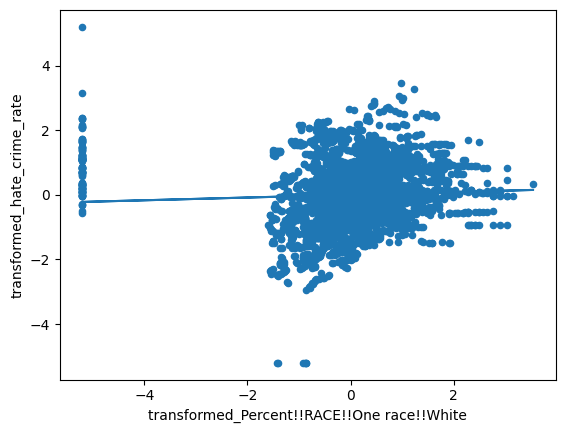

In [171]:
# create a scatter plot of the data
county_hate_rates_df.plot.scatter(x=review_features, y="transformed_hate_crime_rate")

#replace coefficients[0] with coefficients[x_train_df.columns.get_loc(review_features)] if training on x_train_df
y_pred = pd.Series(coefficients[0] * x[review_features])

# plot the line of best fit
plt.plot(x, y_pred)


In [172]:
lr_rmse = sk.metrics.mean_squared_error(y_train_df, y_pred, squared=False)
lr_mae = sk.metrics.mean_absolute_error(y_train_df, y_pred)
print("Linear Regression RMSE: " + str(lr_rmse))
print("Linear Regression MAE: " + str(lr_mae))

Linear Regression RMSE: 1.0152673765866107
Linear Regression MAE: 0.801472474197714


###K-Nearest-Neighbors on Review Feature

KeyboardInterrupt: 

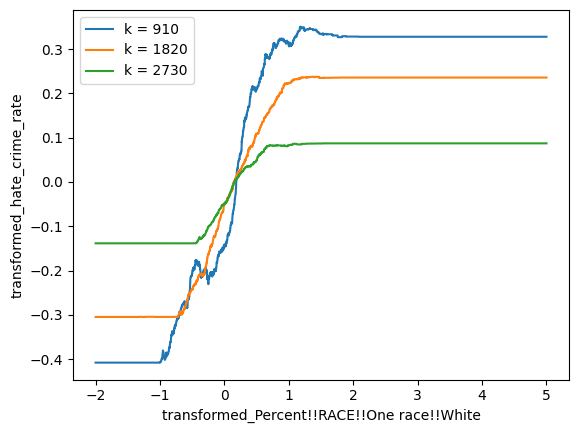

In [173]:
# reformat the training data
x = pd.DataFrame(x_train_df[review_features])

# create the test data
x_test = pd.DataFrame()
x_test[review_features] = np.linspace(-2, 5, len(y_train_df))

errors_by_k_df = pd.DataFrame({
    "k": [np.nan],
    "rmse": [np.nan],
    "mae": [np.nan]
})

increment = 0.05
# try various different values of k
for k in range(20, len(x), 5):
    # create and fit the model
    hate_knn_model = KNeighborsRegressor(n_neighbors=k)
    hate_knn_model.fit(X=x, y=y_train_df)

    # get the model's predictions
    y_pred = pd.Series(
        hate_knn_model.predict(x_test),
        index=x_test[review_features]
    )

    rmse = sk.metrics.mean_squared_error(y_train_df, y_pred, squared=False)
    mae = sk.metrics.mean_absolute_error(y_train_df, y_pred)
    entry = {
        "k": k,
        "rmse": rmse,
        "mae": mae
    }

    errors_by_k_df.loc[len(errors_by_k_df)] = entry

    if (k % int(increment * len(x_train_df)) == 0):
      # plot knn model predictions
      y_pred.plot.line(ylabel="transformed_hate_crime_rate",\
                      label=("k = " + str(k)))\
                      .legend()


errors_by_k_df.dropna(inplace=True)
# errors_by_k_df.set_index("k", inplace=True)

# create a scatter plot of the data
county_hate_rates_df.plot.scatter(x=review_features,\
                                  y="transformed_hate_crime_rate",\
                                  alpha=0.5,\
                                  ylabel="transformed_hate_crime_rate")

# create a scatter plot of the rmse's
errors_by_k_df.plot.line(x="k",\
                       y="rmse",\
                       alpha=0.5,\
                       logy=True,\
                       ylabel="transformed_hate_crime_rate")

In [ ]:
errors_by_k_df.head()

###Comparison of Methods

In [ ]:
best_knn_score_i = errors_by_k_df["mae"].idxmin()

print("Linear Regression Metric Scores:")
print("RMSE:\t\t" + str(lr_rmse))
print("MAE:\t\t" + str(lr_rmse))
print()
print("KNN Metric Scores:")
print("Best k:\t" + str(errors_by_k_df.loc[best_knn_score_i, "k"]))
print("Lowest RMSE:\t" + str(errors_by_k_df.loc[best_knn_score_i, "rmse"]))
print("Lowest MAE:\t" + str(errors_by_k_df.loc[best_knn_score_i, "mae"]))

##Region Classification by Demographics

In [174]:
classification_df = county_hate_rates_df[training_cols + ["region", "transformed_hate_crime_rate"]]

KeyError: "['region'] not in index"

In [175]:
region_name_map = {
    0:"Northeast",
    1:"Midwest",
    2:"West",
    3:"South"
}

color_map = {
    0: 'red',
    1: 'orange',
    2: 'yellow',
    3: 'green',
    4: 'blue',
    5: 'purple'
}

###K-Means Clustering

In [176]:
classification_df.head()

NameError: name 'classification_df' is not defined

####Feature selection

In [ ]:
# create the classifier
km_model = KMeans(n_clusters=4, random_state=69)

best_clustering = {
    "features": [],
    "k": 0,
    "silhouette_score": -1
}

In [ ]:
# saved to skip below and reduce future runtime
best_clustering = {
    "features": ['transformed_Percent!!RACE!!One race!!Asian!!Asian Indian',\
                   'transformed_Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Native Hawaiian and Other Pacific Islander alone'],
    "k": 4,
    "silhouette_score": 0.7786296441943121
}

In [ ]:
# clusterable_feature_pairs = []

# for k in [4]:
#   for i in range(int((4 * len(extracted_sorted_corrs))/8), int((5 * len(extracted_sorted_corrs))/8)):  #len(extracted_sorted_corrs)):
#       row = extracted_sorted_corrs.iloc[i]

#       features = list(row[["feature1", "feature2"]])

#       # create the classifier
#       km_model = KMeans(n_clusters=k, random_state=69)

#       x = classification_df[features + ["region"]]

#       # # fit the classifier to the feature data
#       # km_model.fit(x)

#       # cluster the features
#       predictions = km_model.fit_predict(x)

#       # get the silhouette score
#       silhouette_score = metrics.silhouette_score(x, predictions)

#       # If it's got some pretty good clusters
#       if (silhouette_score > 0.5):
#         clusterable_feature_pairs.append(features)

#         #if it's got good enough clusters, display it
#         if (silhouette_score > 0.9):
#           county_hate_rates_df.plot.scatter(x=row["feature1"],\
#                                       y=row["feature2"],\
#                                       title="Silhouette Score = " + str(silhouette_score),\
#                                       figsize=(12, 12))

#       if (silhouette_score > best_clustering["silhouette_score"]):
#         best_clustering["features"] = features
#         best_clustering["k"] = k
#         best_clustering["silhouette_score"] = silhouette_score


# print("Total clustered feature pairs: " + str(len(clusterable_feature_pairs)))

In [ ]:
print(best_clustering)

In [ ]:
review_features = list(best_clustering["features"])
print(review_features)

####Clustering

In [ ]:
# fit the classifier to the feature best suited to k-means clustering
km_model.fit(classification_df[review_features])

# add the cluster assignment
classification_df['cluster'] = km_model.labels_

In [ ]:
#get the region frequencies associated with each cluster
cluster_regions_df = classification_df\
  .groupby(["cluster", "region"])\
  .size()

cluster_regions_df

In [ ]:
# maps each cluster to a region based on the mode of each cluster
def cluster_region_mapping(cluster_regions_df):
  cluster_region_dict = {}

  # for each cluster and set of associated regions in cluster_regions_df
  for cluster, region_df in cluster_regions_df.groupby(level=0):
    # set that entry of the region map to the most common region membership for classification
    cluster_region_dict[cluster] = region_df.sort_values(ascending=False).index[0][1]

  # return the region mapping dictionary
  return cluster_region_dict

region_map = cluster_region_mapping(cluster_regions_df)
region_map

In [ ]:
#set the k-means predictions for each cluster to the most frequent region membership
classification_df['km_prediction'] = classification_df['cluster'].map(region_map)

#set the k-means predictions for each cluster to the most frequent region membership
classification_df['km_prediction_name'] = classification_df['km_prediction'].map(region_name_map)

In [ ]:
# display the first few rows of the dataframe to verify data
classification_df.head()

In [ ]:
# add a color column to the main df
classification_df['color'] = classification_df['cluster'].map(color_map)

classification_df\
  .groupby('color')\
  .size()\
  .plot\
  .barh(color=sns.palettes.mpl_palette('Dark2'), xlabel="member count", ylabel="cluster", logx=True)

In [ ]:
# color clusters by associated cluster
classification_df\
  .plot\
  .scatter(x=best_clustering["features"][0],\
           y=best_clustering["features"][1],\
           c="color",\
           alpha=0.5,\
           figsize=(12, 12))

In [ ]:
classification_df\
  .groupby('km_prediction_name')\
  .size()\
  .plot\
  .barh(color=sns.palettes.mpl_palette('Dark2'), xlabel="member count", ylabel="predicted region", logx=True)

In [ ]:
# add a color column to the main df
classification_df['color'] = classification_df['km_prediction'].map(color_map)

# color clusters by region majority class
classification_df\
  .plot\
  .scatter(x=best_clustering["features"][0],\
           y=best_clustering["features"][1],\
           c="color",\
           alpha=0.5,\
           figsize=(12, 12))

###Naive Bayes

In [ ]:
gnb_model = GaussianNB()

# predict classification_df['cluster'] from classification_df[review_features]
predictions = gnb_model\
                .fit(classification_df[review_features], county_hate_rates_df["region"])\
                .predict(classification_df[review_features])

classification_df["nb_prediction"] = predictions

classification_df["nb_prediction_name"] = pd.Series(predictions).map(region_name_map)

# get the silhouette score of the Naive Bayes classifier's predictions
gnb_silhouette_score = metrics.silhouette_score(classification_df[review_features], predictions)

In [ ]:
print(gnb_silhouette_score)

In [ ]:
classification_df\
  .groupby('nb_prediction_name')\
  .size()\
  .plot\
  .barh(color=sns.palettes.mpl_palette('Dark2'), xlabel="member count", ylabel="region", logx=True)

In [ ]:
classification_df['color'] = classification_df['nb_prediction'].map(color_map)
print("Legend:\n\
        South: Green\n\
        West: Yellow\n\
        Northeast: Red\n\
        Midwest: Orange")

# plot the features under consideration with the colors determined by the naive bayes classifier
classification_df\
  .plot\
  .scatter(x=best_clustering["features"][0],\
           y=best_clustering["features"][1],\
           c="color",\
           alpha=0.25,\
           figsize=(12, 12))

###Compare Clustering/Classification Models

In [ ]:
y_true = county_hate_rates_df["region"]
averaging_method = "macro"

print("K-Means Metric Scores:")
y_pred = classification_df['km_prediction']
print("Silhouette:\t" + str(best_clustering["silhouette_score"]))
print("Accuracy:\t" + str(metrics.accuracy_score(y_true, y_pred)))
print("Precision:\t" + str(metrics.precision_score(y_true, y_pred, average=averaging_method)))
print("Recall:\t\t" + str(metrics.recall_score(y_true, y_pred, average=averaging_method)))
print("F1:\t\t" + str(metrics.f1_score(y_true, y_pred, average=averaging_method)))

print()

print("Naive Bayes Metric Scores:")
y_pred = classification_df["nb_prediction"]
print("Silhouette:\t" + str(gnb_silhouette_score))
print("Accuracy:\t" + str(metrics.accuracy_score(y_true, y_pred)))
print("Precision:\t" + str(metrics.precision_score(y_true, y_pred, average=averaging_method)))
print("Recall:\t\t" + str(metrics.recall_score(y_true, y_pred, average=averaging_method)))
print("F1:\t\t" + str(metrics.f1_score(y_true, y_pred, average=averaging_method)))